# Prediction notebook

This notebook allows replicating the figures and showcase how predictions can be made from the trained networks.

In [1]:
# (c) Charles Le Losq 2021
# see embedded licence file

#
# Library loading and additional function definition
#
%matplotlib inline

# dataframes and arrays
import pandas as pd 
import numpy as np
import seaborn as sns

# for plotting
import matplotlib.pyplot as plt 
import matplotlib, mpltern, corner
from mpltern.ternary.datasets import get_spiral
from matplotlib.patches import ArrowStyle, FancyArrowPatch
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

# spearman corr coef
from scipy.stats import spearmanr

# mse
from sklearn.metrics import mean_squared_error

# imelt internals
import imelt

# other essentials
import torch, time, h5py

# for peak fitting
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import rampy as rp

# we will work on CPU there
device = torch.device('cpu') #get_default_device()
print(device)


cpu


# Loading dataset and models

In [2]:
path_data = "./data/NKAS_viscosity_reference.hdf5"
path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"
path_optical = "./data/NKAS_optical.hdf5"

ds = imelt.data_loader(path_data,path_raman,path_density,path_optical,device)

path = "./model/best/"
name_list = pd.read_csv("./model/best/best_list.csv").loc[:,"name"]
neuralmodel = imelt.bagging_models(path, name_list, ds, device)

ds.print_data()

################################
#### Dataset specifications ####
################################

Number of unique compositions (viscosity): 173
Number of unique compositions in training (viscosity): 113
Dataset separations are 0.65 in train, 0.14 in valid, 0.21 in test

Number of unique compositions (entropy): 44
Number of unique compositions in training (entropy): 30
Dataset separations are 0.68 in train, 0.16 in valid, 0.16 in test

Number of unique compositions (refractive index): 223
Number of unique compositions in training (refractive index): 160
Dataset separations are 0.72 in train, 0.14 in valid, 0.14 in test

Number of unique compositions (density): 205
Number of unique compositions in training (density): 139
Dataset separations are 0.68 in train, 0.16 in valid, 0.16 in test

Number of unique compositions (Raman): 58
Number of unique compositions in training (Raman): 48
Dataset separations are 0.83 in train, 0.17 in valid

This is for checking the consistency of the datase

# Predictions on provided data

In [3]:
y_ag_train = neuralmodel.predict("ag",ds.x_visco_train,ds.T_visco_train)
y_ag_valid = neuralmodel.predict("ag",ds.x_visco_valid,ds.T_visco_valid)
y_ag_test = neuralmodel.predict("ag",ds.x_visco_test,ds.T_visco_test)

y_tvf_train = neuralmodel.predict("tvf",ds.x_visco_train,ds.T_visco_train)
y_tvf_valid = neuralmodel.predict("tvf",ds.x_visco_valid,ds.T_visco_valid)
y_tvf_test = neuralmodel.predict("tvf",ds.x_visco_test,ds.T_visco_test)

y_myega_train = neuralmodel.predict("myega",ds.x_visco_train,ds.T_visco_train)
y_myega_valid = neuralmodel.predict("myega",ds.x_visco_valid,ds.T_visco_valid)
y_myega_test = neuralmodel.predict("myega",ds.x_visco_test,ds.T_visco_test)

y_am_train = neuralmodel.predict("am",ds.x_visco_train,ds.T_visco_train)
y_am_valid = neuralmodel.predict("am",ds.x_visco_valid,ds.T_visco_valid)
y_am_test = neuralmodel.predict("am",ds.x_visco_test,ds.T_visco_test)

y_cg_train = neuralmodel.predict("cg",ds.x_visco_train,ds.T_visco_train)
y_cg_valid = neuralmodel.predict("cg",ds.x_visco_valid,ds.T_visco_valid)
y_cg_test = neuralmodel.predict("cg",ds.x_visco_test,ds.T_visco_test)

# our real x axis, for resampling
x_raman_shift = np.arange(400.,1250.,1.0)

raman_train_predictions = neuralmodel.predict("raman_pred",ds.x_raman_train).mean(axis=2)
raman_valid_predictions = neuralmodel.predict("raman_pred",ds.x_raman_valid).mean(axis=2)

# Figure 3

This figure presents the deep learning model, viscosity predictions for melts with ~66 mol% silica and different Al/Si ratios, and Raman spectra predictions.

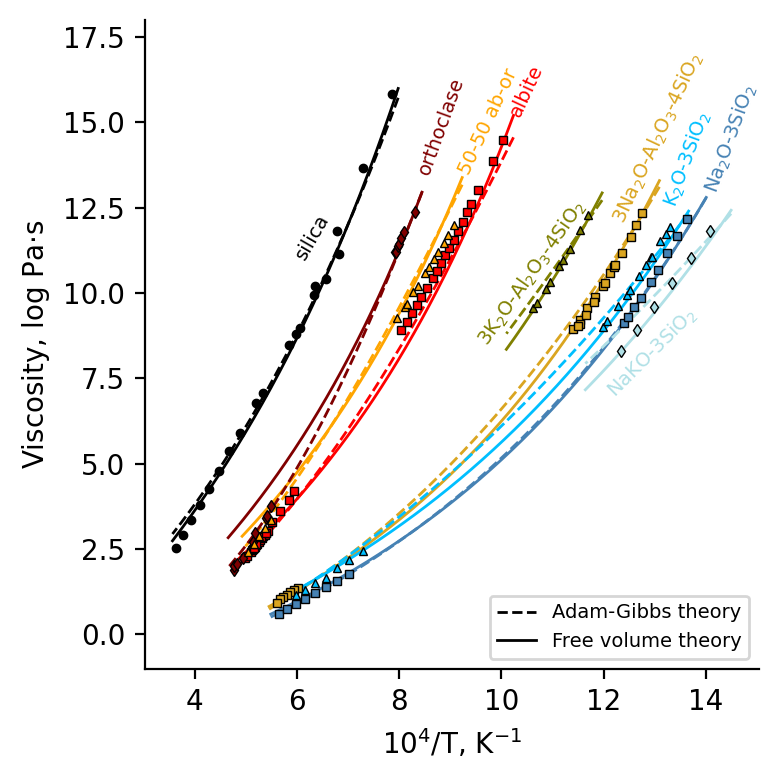

In [4]:
#
# For simplicity, data were saved in an external file
# we load it below
#
df2 = pd.read_excel("./data/Database_IPGP.xlsx",sheet_name="VISCO")
silica = df2.loc[df2.Name=="SiO2",:].reset_index()
NS3 = df2.loc[df2.Name=="NS75",:].reset_index()
KS3 = df2.loc[df2.Name=="KS75",:].reset_index()
NKS3 = df2.loc[df2.Name=="NKS75_11",:].reset_index()
Ab = df2.loc[df2.Name=="NAK75_12_0",:].reset_index()
Or = df2.loc[df2.Name=="NAK75_12_12",:].reset_index()
AbOr = df2.loc[df2.Name=="NAK75_12_6",:].reset_index()
NAS = df2.loc[df2.Name=="NA65_9",:].reset_index()
KAS = df2.loc[df2.Name=="KA65_9",:].reset_index()

#
# We define utility functions to do the figure below
#
def plot_viscocurve(ax,dts,method = "ag",color="k",marker="s",linestyle="-"):
    """plot viscosity predictions given some arguments"""
    x_inter = np.arange(dts.loc[:,"T"].min()-20,dts.loc[:,"T"].max()+50,1.0)
    if dts.loc[0,"sio2"] > 1:
        ax.plot(10000/x_inter,
                 neuralmodel.predict(method,
                                     torch.Tensor(dts.loc[0,"sio2":"k2o"].values.astype('float')*np.ones((len(x_inter),4))/100).to(device),
                                     torch.Tensor(x_inter.reshape(-1,1)).to(device)).mean(axis=1),
                color=color, linestyle=linestyle, linewidth=1,
            )
    else:
        ax.plot(10000/x_inter,
                 neuralmodel.predict(method,
                                     torch.Tensor(dts.loc[0,"sio2":"k2o"].values.astype('float')*np.ones((len(x_inter),4))).to(device),
                                     torch.Tensor(x_inter.reshape(-1,1)).to(device)).mean(axis=1),
                color=color, linestyle=linestyle, linewidth=1,
            )
    return ax

#
# The following is not used and only kept for documentation. It allows performing a 3D plot
#
def prepare_data_fig2(neuralmodel,sio2,al2o3,alkalis, xk_ = np.arange(0,1,0.01), T_ = np.arange(650,2000,1.0)):
    """prepare xk mapping for surface plot of figure 3"""
    xk_plot = []
    T_plot = []
    for count,value in enumerate(xk_):
        X__ = np.vstack([sio2*np.ones(len(T_)),
                         al2o3*np.ones(len(T_)),
                         alkalis*(1-value*np.ones(len(T_))),
                         alkalis*value*np.ones(len(T_))]).T
        if count == 0:
            xk_plot = value*np.ones(len(T_))
            T_plot = T_.copy()
            n_plot = neuralmodel.predict("cg",X__,np.array(T_).reshape(-1,1)).mean(axis=-1)
        else:
            xk_plot = np.vstack((xk_plot,value*np.ones(len(T_))))
            T_plot = np.vstack((T_plot,T_))
            n_plot = np.vstack((n_plot,neuralmodel.predict("ag",X__,np.array(T_).reshape(-1,1)).mean(axis=-1)))
    
    return xk_plot, T_plot, n_plot

#
# now we prepare the different datasets
# this is useful if one wants to visualize the 3D plot below and can be commented if not, as it is slow.
#
#xk_plot_NKS, T_plot_NKS, n_plot_NKS  = prepare_data_fig2(neuralmodel,0.67,0.0,0.33)
#xk_plot_Jad, T_plot_Jad, n_plot_Jad = prepare_data_fig2(neuralmodel,0.67,0.165,0.165,T_ = np.arange(1050,2000,1.0))
#xk_plot_6509, T_plot_6509, n_plot_6509 = prepare_data_fig2(neuralmodel,0.66,0.09,0.25,T_ = np.arange(750,2000,1.0))

### 
### FIGURE 3 GENERATION
###

fig3 = plt.figure(figsize=(4,4),dpi=200)

gs = GridSpec(1, 1, figure=fig3)
#ax1 = fig.add_subplot(gs[0, :])

ax = fig3.add_subplot(gs[0, 0])

#
# colors
#
colors = {'NS66':'steelblue',
          'KS66':'deepskyblue',
          'NKS66':'powderblue',
          'SiO2':'black',
          'albite':'red',
          'AbOr':'orange',
          'orthoclase':'maroon',
          'NA65_9':'goldenrod',
          'KA65_9':'olive',
          'mec1':'black',
          'mec2':'black'}
mew=0.5

#
# for the dummy legend
#
ax.plot([],[],"k--",lw=1,label="Adam-Gibbs theory")
ax.plot([],[],"k-",lw=1,label="Free volume theory")
ax.legend(loc="lower right", fontsize=7)

#
# data
#

plot_viscocurve(ax, Ab,method = "cg",color=colors['albite'])
plot_viscocurve(ax, AbOr,method = "cg",color=colors['AbOr'])
plot_viscocurve(ax, Or,method = "cg",color=colors['orthoclase'])
plot_viscocurve(ax, Ab,method = "ag",linestyle="--",color=colors['albite'])
plot_viscocurve(ax, AbOr,method = "ag",linestyle="--",color=colors['AbOr'])
plot_viscocurve(ax, Or,method = "ag",linestyle="--",color=colors['orthoclase'])

plot_viscocurve(ax, NAS,method = "ag",linestyle="--",color=colors['NA65_9'])
plot_viscocurve(ax, KAS,method = "ag",linestyle="--",color=colors['KA65_9'])
plot_viscocurve(ax, NAS,method = "cg",linestyle="-",color=colors['NA65_9'])
plot_viscocurve(ax, KAS,method = "cg",linestyle="-",color=colors['KA65_9'])

plot_viscocurve(ax, silica,method = "cg",color=colors['SiO2'])
plot_viscocurve(ax, NS3,method = "cg",color=colors['NS66'])
plot_viscocurve(ax, NKS3,method = "cg",color=colors['NKS66'])
plot_viscocurve(ax, KS3,method = "cg",color=colors['KS66'])
plot_viscocurve(ax, silica,method = "ag",linestyle="--",color=colors['SiO2'])
plot_viscocurve(ax, NS3,method = "ag",linestyle="--",color=colors['NS66'])
plot_viscocurve(ax, NKS3,method = "ag",linestyle="--",color=colors['NKS66'])
plot_viscocurve(ax, KS3,method = "ag",linestyle="--",color=colors['KS66'])

markersize=3

ax.plot(10000/Ab.loc[:,"T"],Ab.viscosity,"s",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['albite'])
ax.plot(10000/Or.loc[:,"T"],Or.viscosity,"d",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['orthoclase'])
ax.plot(10000/AbOr.loc[:,"T"],AbOr.viscosity,"^",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['AbOr'])
ax.plot(10000/NAS.loc[:,"T"],NAS.viscosity,
        "s",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['NA65_9'])
ax.plot(10000/KAS.loc[:,"T"],KAS.viscosity,
        "^",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['KA65_9'])

ax.plot(10000/silica.loc[:,"T"],silica.viscosity,"o",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['SiO2'])
ax.plot(10000/NS3.loc[:,"T"],NS3.viscosity,"s",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['NS66'])
ax.plot(10000/NKS3.loc[:,"T"],NKS3.viscosity,"d",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['NKS66'])
ax.plot(10000/KS3.loc[:,"T"],KS3.viscosity,"^",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['KS66'])

# axes labels
ax.set_ylabel("Viscosity, log Pa$\cdot$s")
ax.set_xlabel("$10^4$/T, K$^{-1}$")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set axes
ax.set_ylim(-1,18)

#
# Annotations on plot of viscosity
#

ax.annotate("silica",xy=(5.9,11.0), xycoords="data", fontsize=7, rotation=60, color="black")
ax.annotate("orthoclase",xy=(8.3,13.5), xycoords="data", fontsize=7, rotation=70, color=colors['orthoclase'])
ax.annotate("albite",xy=(10.1,15.2), xycoords="data", fontsize=7, rotation=65, color=colors['albite'])
ax.annotate("50-50 ab-or",xy=(9.1,13.5), xycoords="data", fontsize=7, rotation=65, color=colors['AbOr'])
ax.annotate("3Na$_2$O-Al$_2$O$_3$-4SiO$_2$", xy=(12.1,12.1), xycoords="data", fontsize=7, rotation=65, color=colors['NA65_9'])
ax.annotate("3K$_2$O-Al$_2$O$_3$-4SiO$_2$", xy=(9.45,8.5), xycoords="data", fontsize=7, rotation=55, color=colors['KA65_9'])
ax.annotate("Na$_2$O-3SiO$_2$",xy=(13.9,13.), xycoords="data", fontsize=7, rotation=70, color= colors['NS66'])
ax.annotate("K$_2$O-3SiO$_2$",xy=(13.1,12.6), xycoords="data", fontsize=7, rotation=70, color= colors['KS66'])
ax.annotate("NaKO-3SiO$_2$",xy=(12.,6.95), xycoords="data", fontsize=7, rotation=45, color= colors['NKS66'])

plt.tight_layout()
plt.savefig("./figures/Figure3.pdf")

# Predictions of Raman spectra along the Na2O-SiO2 join

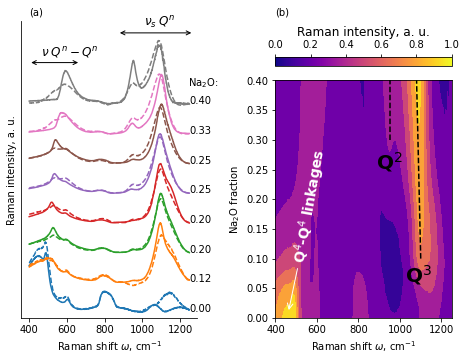

In [5]:
#
# Fiddling with the dataset to get Raman spectra of NS glasses
#
dd_raman = np.vstack((ds.x_raman_train.numpy(),ds.x_raman_valid.numpy()))
yy_raman = np.vstack((ds.y_raman_train.numpy(),ds.y_raman_valid.numpy()))
xx_NS_raman = dd_raman[(dd_raman[:,1] == 0)&(dd_raman[:,3]==0)]
yy_NS_raman = yy_raman[(dd_raman[:,1] == 0)&(dd_raman[:,3]==0)]

yy_pred_raman = np.vstack((raman_train_predictions,raman_valid_predictions))

# for sorting the Raman spectra
idx_sort_NS_raman = np.argsort(xx_NS_raman[:,0], axis=0)

#
# Figure declaration
#
fig4 = plt.figure(figsize=(6.5,5))

ax = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

#
# SUBPLOT A
#

shift = 0 # for a Y shift of the spectra
for num,i in enumerate(idx_sort_NS_raman[::-1]):

    ax.plot(x_raman_shift, yy_NS_raman[i,:]+shift, 
             color="C"+str(num))
    ax.plot(x_raman_shift, yy_pred_raman[(dd_raman[:,1] == 0)&(dd_raman[:,3]==0)][i,:]+shift, 
             "--", color="C"+str(num))
    
    ax.annotate("{:.2f}".format(xx_NS_raman[i,2]), xy=(1250,shift), xycoords="data")
    shift += 0.5
    
# axes labels
ax.set_ylabel("Raman intensity, a. u.")
ax.set_yticks([])

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# make arrows indicating the vibrations, and annotations
ax.annotate('', xy=(400,4.2), xytext=(670,4.2), xycoords="data",arrowprops=dict(arrowstyle='<->'))
ax.annotate(r"$\nu \; Q^{n}-Q^{n}$",xy = (460,4.3),xycoords="data",fontsize=12)

ax.annotate('', xy=(870,4.7), xytext=(1270,4.7), xycoords="data",arrowprops=dict(arrowstyle='<->'))
ax.annotate(r"$\nu_s \; Q^{n}$",xy = (1010,4.8),xycoords="data",fontsize=12)

ax.annotate("Na$_2$O:", xy=(1240, shift-0.2), xycoords="data")

ax.set_ylim(-0.1,4.9)
plt.tight_layout()

#
# SUBPLOT 2
#

c_m = matplotlib.cm.plasma # choose a colormap
s_m = matplotlib.cm.ScalarMappable(cmap=c_m) # create a ScalarMappable and initialize a data structure

X_fig4 = np.zeros((100,4))
X_fig4[:,0 ] = np.linspace(1.0, 0.6, num=100)
X_fig4[:,2 ] = np.linspace(0.0, 0.4, num=100)
fig4_raman_pred = neuralmodel.predict("raman_pred",X_fig4)

ax2.contourf((np.ones((len(x_raman_shift),100))*x_raman_shift.reshape(-1,1)),
                (np.ones((len(x_raman_shift),100))*X_fig4[:,2].reshape(1,-1)),
                fig4_raman_pred.mean(axis=2).T, cmap=c_m)


ax.set_xlabel("Raman shift $\omega$, cm$^{-1}$")
ax2.set_xlabel("Raman shift $\omega$, cm$^{-1}$")
ax2.set_ylabel("Na$_2$O fraction")

plt.tight_layout() # we call now the tight layout because the colorbar moves it...

cbar_ = plt.colorbar(mappable=s_m, ax=[ax2,], location='top')
cbar_.set_label(r"Raman intensity, a. u.", fontsize=12)

plt.annotate("Q$^4$-Q$^4$ linkages", xy=(462,0.01), xytext=(470, 0.1), 
             color="white", fontsize=14, rotation = 80, fontweight="bold",
            arrowprops=dict(arrowstyle="->",color="white"))

plt.annotate("Q$^2$", xy=(950,0.25), color="black", fontsize=20, rotation = 0, fontweight="bold", ha="center")
plt.plot([950, 950], [0.30,0.40], "--k")

plt.annotate("Q$^3$", xy=(1090,0.06), 
             color="black", fontsize=20, rotation = 0, 
             fontweight="bold", ha="center",
            )
plt.plot([1100, 1080], [0.10,0.40], "--k")

ax.text(400, 5.0, "(a)")
ax2.text(400, 0.51, "(b)")

plt.savefig("./figures/Figure4.pdf")

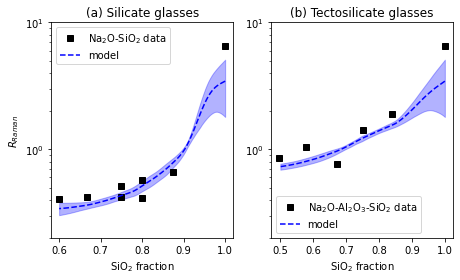

In [6]:
R_Raman_NS_data = imelt.R_Raman(x_raman_shift, yy_NS_raman)

R_Raman_NS_model = np.zeros((100,10))
for i in range(10):
    R_Raman_NS_model[:,i] = imelt.R_Raman(x_raman_shift,fig4_raman_pred[:,:,i])

nbot_data = (2*xx_NS_raman[:,2])/xx_NS_raman[:,0]
nbot_model = (2*X_fig4[:,2])/X_fig4[:,0]
    
plt.figure(figsize=(6.5,4))

# Plotting the data
ax = plt.subplot(1,2,1)

ax.plot(xx_NS_raman[:,0], R_Raman_NS_data, "ks", label="Na$_2$O-SiO$_2$ data")

# Plotting the model results
plt.plot(X_fig4[:,0], R_Raman_NS_model.mean(axis=1), "b--", label="model")

plt.fill_between(X_fig4[:,0], 
                 R_Raman_NS_model.mean(axis=1)-2*R_Raman_NS_model.std(axis=1),
                R_Raman_NS_model.mean(axis=1)+2*R_Raman_NS_model.std(axis=1),
                alpha=0.3, color="b")

plt.legend(loc="best")

plt.ylim(0.2,10)
plt.yscale('log')

plt.ylabel('$R_{Raman}$')
plt.xlabel('SiO$_2$ fraction')

#
# Construction of SUBPLOT B
# NAS tectosilicate join = topology and Si-Al ordering
#
ax2 = plt.subplot(1,2,2)

#
# Fiddling with the dataset to get Raman spectra of NAS tectosilicate glasses
#

xx_NAS_raman = dd_raman[((dd_raman[:,1] - dd_raman[:,2])**2 < 0.001)&(dd_raman[:,3]==0)]
yy_NAS_raman = yy_raman[((dd_raman[:,1] - dd_raman[:,2])**2 < 0.001)&(dd_raman[:,3]==0)]
R_Raman_NAS_data = imelt.R_Raman(x_raman_shift, yy_NAS_raman)

# generating model values
X_fig5 = np.zeros((100,4))
X_fig5[:,0 ] = np.linspace(1.0, 0.5, num=100)
X_fig5[:,1] = (1-X_fig5[:,0 ])/2
X_fig5[:,2] = (1-X_fig5[:,0 ])/2
fig5_raman_pred = neuralmodel.predict("raman_pred",X_fig5)

R_Raman_NAS_model = np.zeros((100,10))
for i in range(10):
    R_Raman_NAS_model[:,i] = imelt.R_Raman(x_raman_shift,fig5_raman_pred[:,:,i])

# Plotting the data
ax2.plot(xx_NAS_raman[:,0], R_Raman_NAS_data, "ks", label="Na$_2$O-Al$_2$O$_3$-SiO$_2$ data")    

# Plotting the model results
ax2.plot(X_fig5[:,0], R_Raman_NAS_model.mean(axis=1), "b--", label="model")

ax2.fill_between(X_fig5[:,0], 
                 R_Raman_NAS_model.mean(axis=1)-2*R_Raman_NAS_model.std(axis=1),
                R_Raman_NAS_model.mean(axis=1)+2*R_Raman_NAS_model.std(axis=1),
                alpha=0.3, color="b")

plt.ylim(0.2,10)
plt.yscale('log')
plt.xlabel('SiO$_2$ fraction')
plt.legend()

ax.set_title("(a) Silicate glasses")
ax2.set_title("(b) Tectosilicate glasses")
plt.tight_layout()

plt.savefig("./figures/Figure5.pdf")

# Raman spectra

The code below allows us to predict Raman spectra corresponding to those in the training and validation.

We generate a figure comparing predictions and observations.

Least-Absolute Deviations are also calculated, as well as the R_Raman parameters.

Median of the Relative Least Absolute Deviation on Train Raman dataset is 21.32%
Median of the Relative Least Absolute Deviation on Valid Raman dataset is 25.60%
Relavive LAD on Training R_Raman: 15.86
Relavive LAD on Validation R_Raman: 25.53


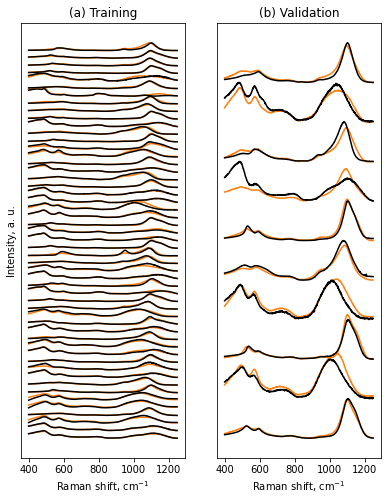

In [7]:
#
# Figure comparing Raman data to predictions
#

plt.figure(figsize=(6.44,8))

plt.subplot(1,2,1)
plt.title("(a) Training")
Raman_error_train = np.zeros(ds.x_raman_train.shape[0])
shift = 0.
for i in range(ds.x_raman_train.shape[0]):
    Raman_error_train[i] = np.mean(np.abs(raman_train_predictions[i,:]-ds.y_raman_train[i,:].detach().numpy())/raman_train_predictions[i,:])
    plt.plot(x_raman_shift,raman_train_predictions[i,:]+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_train[i,:].detach().numpy()+shift,"k-")
    shift += 1.
plt.xlabel("Raman shift, cm$^{-1}$")
plt.ylabel("Intensity, a. u.")
plt.yticks([])

print("Median of the Relative Least Absolute Deviation on Train Raman dataset is {0:.2f}%".format(np.median(Raman_error_train)*100))

plt.subplot(1,2,2)
plt.title("(b) Validation")
Raman_error_valid = np.zeros(ds.x_raman_valid.shape[0])
shift = 0.
for i in range(ds.x_raman_valid.shape[0]):
    Raman_error_valid[i] = np.mean(np.abs(raman_valid_predictions[i,:]-ds.y_raman_valid[i,:].detach().numpy())/raman_valid_predictions[i,:])
    plt.plot(x_raman_shift,raman_valid_predictions[i,:]+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_valid[i,:].detach().numpy()+shift,"k-")
    shift += 1.

plt.yticks([])
    
plt.xlabel("Raman shift, cm$^{-1}$")

print("Median of the Relative Least Absolute Deviation on Valid Raman dataset is {0:.2f}%".format(np.median(Raman_error_valid)*100))

#
# Calculating the R_Raman
#


Rr_train = imelt.R_Raman(x_raman_shift, ds.y_raman_train.detach().numpy())
Rr_valid = imelt.R_Raman(x_raman_shift, ds.y_raman_valid.detach().numpy())

Rr_train_pred = imelt.R_Raman(x_raman_shift, raman_train_predictions)
Rr_valid_pred = imelt.R_Raman(x_raman_shift, raman_valid_predictions)

print('Relavive LAD on Training R_Raman: {:.2f}'.format(100*np.mean(np.abs(Rr_train-Rr_train_pred)/Rr_train)))
print('Relavive LAD on Validation R_Raman: {:.2f}'.format(100*np.mean(np.abs(Rr_valid-Rr_valid_pred)/Rr_valid_pred)))

## SAMPLING THE CHEMICAL SYSTEM

Below we generate the necessary data to map various properties, like the configurational entropy, in the entire glass-forming domain of the Na2O-K2O-Al2O3-SiO2 system.

In practice, we generate many different random Na2O-K2O-Al2O3-SiO2 compositions. With 10000 data or more, this allows drawing accurate maps.

In [8]:
#
# random composition generation
#
nb_samples = 10000

sio2_gen = np.random.random_sample(nb_samples)*0.6 + 0.4
reminder = 1.0 - sio2_gen
R_MAl = np.random.random_sample(nb_samples)#*(1.0-0.4) + 0.4 # ratio of alkalis to Al
al2o3_gen = (1.0 - R_MAl)*reminder
na2o_gen = 1 - sio2_gen - al2o3_gen
k2o_gen = 1 - sio2_gen - al2o3_gen

X_gen_NAS = pd.DataFrame()
X_gen_NAS["sio2"] = sio2_gen
X_gen_NAS["al2o3"] = al2o3_gen
X_gen_NAS["na2o"] = na2o_gen
X_gen_NAS["k2o"] = 0.0
X_gen_NAS_rec = X_gen_NAS.copy()

X_gen_KAS = X_gen_NAS.copy()
X_gen_KAS["k2o"] = k2o_gen
X_gen_KAS["na2o"] = 0.0
X_gen_KAS_rec = X_gen_KAS.copy()

frames = [X_gen_NAS_rec, X_gen_KAS_rec]

X_gen_NAS = torch.Tensor(X_gen_NAS.values).to(device)
X_gen_KAS = torch.Tensor(X_gen_KAS.values).to(device)
X_gen_all = torch.Tensor(pd.concat(frames).values).to(device)

cart_NAS = imelt.bary2cart(X_gen_NAS_rec.loc[:,["na2o","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))
cart_KAS = imelt.bary2cart(X_gen_KAS_rec.loc[:,["k2o","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))

#
# For entropy map during mixing
#

def generate_compo(sio2,R_MAl):
    
    xk = np.linspace(0.,1.,500)

    master_df = pd.DataFrame()
    master_df['sio2'] = sio2[0]*np.ones(500)
    reminder = 1 - master_df['sio2']
    master_df['al2o3'] = R_MAl * reminder
    alkalis = 1 - master_df['sio2'] - master_df['al2o3']
    master_df['na2o'] = (1-xk)*alkalis
    master_df['k2o'] = xk*alkalis
    master_df['xk'] = xk
    
    for i in range(1,len(sio2)):
        ddd = pd.DataFrame()
        ddd['sio2'] = sio2[i]*np.ones(500)
        reminder = 1 - ddd['sio2']
        ddd['al2o3'] = R_MAl * reminder
        alkalis = 1 - ddd['sio2'] - ddd['al2o3']
        ddd['na2o'] = (1-xk)*alkalis
        ddd['k2o'] = xk*alkalis
        ddd['xk'] = xk
        
        master_df = pd.concat([master_df,ddd])
        
    return master_df
        
sio2_gen = np.arange(0.5,0.999,0.005)

X_gen_RS_Xk_rec = generate_compo(sio2_gen, 0.0)
X_gen_R3_Xk_rec = generate_compo(sio2_gen, 0.25)
X_gen_R2_Xk_rec = generate_compo(sio2_gen, 0.4)
X_gen_R1_Xk_rec = generate_compo(sio2_gen, 0.5)

# Correlations between melt/glass parameters and latent variables

To do that, we generate 10,000 random compositions, make predictions of several parameters, and look at the relationship between them.

In [9]:
#
# number of samples
#

nb_samples = 10000

#
# Generating the random compositions in the delimited ternary diagram
#

sio2_gen = np.random.random_sample(nb_samples)*0.5 + 0.5

reminder = 1.0 - sio2_gen

R_MAl = np.random.random_sample(nb_samples)*(1.0-0.4) + 0.4 # ratio of alkalis to Al

R_XK = np.random.random_sample(nb_samples) # ratio K/(K+Na)

al2o3_gen = (1.0 - R_MAl)*reminder

reminder = 1 - sio2_gen - al2o3_gen

na2o_gen = reminder*(1.0-R_XK)
k2o_gen = 1 - sio2_gen - al2o3_gen - na2o_gen

X_gen = pd.DataFrame()
X_gen["sio2"] = sio2_gen
X_gen["al2o3"] = al2o3_gen
X_gen["na2o"] = na2o_gen
X_gen["k2o"] = k2o_gen
M_glass = sio2_gen*60.08 + al2o3_gen*101.96 + na2o_gen*61.9789 + k2o_gen*94.2
X_rec = X_gen.copy() # this is to have a copy (non-torch, pandas)
X_gen = torch.Tensor(X_gen.values).to(device)

#
# Making predictions
#

Raman_gen = neuralmodel.predict("raman_pred",X_gen).mean(axis=2)

Rr_gen = np.trapz(Raman_gen[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(Raman_gen[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

# all parameters

samples = np.concatenate((neuralmodel.predict("a_tvf",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("a_am",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("ae",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("a_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("b_tvf",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("be",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("b_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("c_tvf",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("sctg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("to_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("c_cg",X_gen).mean(axis=1).reshape(-1,1),
                          
                          neuralmodel.predict("be",X_gen).mean(axis=1).reshape(-1,1)/neuralmodel.predict("sctg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("fragility",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("density",X_gen).mean(axis=1).reshape(-1,1),
                          M_glass.reshape(-1,1)/neuralmodel.predict("density",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("tg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("sellmeier",X_gen,lbd=589.0*np.ones((len(X_gen),1))).mean(axis=1).reshape(-1,1),
                          Rr_gen.reshape(-1,1)
                         ),axis=1)

labels = [r"$A_{VFT}$", r"$A_{AM}$", r"$A_e$", r"$A_{FV}$",   
          r"$B_{VFT}$", r"$B_e$", r"$B_{FV}$", 
          r"$C_{VFT}$", r"$S^{conf}(T_g)$", r"$T_o$", r"$C_{FV}$",
          r"$B_e/S^{conf}(T_g)$", 
          r"m", r"d", r"$V_m$",r"$T_g$",r"$n_{589}$", r"R$_{Raman}$"]

# subset of highly correlated parameters

samples_2 = np.concatenate((neuralmodel.predict("sellmeier",X_gen,lbd=589.0*np.ones((len(X_gen),1))).mean(axis=1).reshape(-1,1),
                            neuralmodel.predict("be",X_gen).mean(axis=1).reshape(-1,1)/neuralmodel.predict("sctg",X_gen).mean(axis=1).reshape(-1,1),
                            neuralmodel.predict("b_cg",X_gen).mean(axis=1).reshape(-1,1)/neuralmodel.predict("c_cg",X_gen).mean(axis=1).reshape(-1,1),
                            neuralmodel.predict("tg",X_gen).mean(axis=1).reshape(-1,1),
                            Rr_gen.reshape(-1,1)
                           ),axis=1)

labels_2 = [r"$n_{589}$", r"$B_e/S^{conf}(T_g)$", r"$B_{CG}$", r"$T_g$", r"R$_{Raman}$"]

### Notebook figure : general correlation plot of all predicted variables

<Figure size 1080x1080 with 0 Axes>

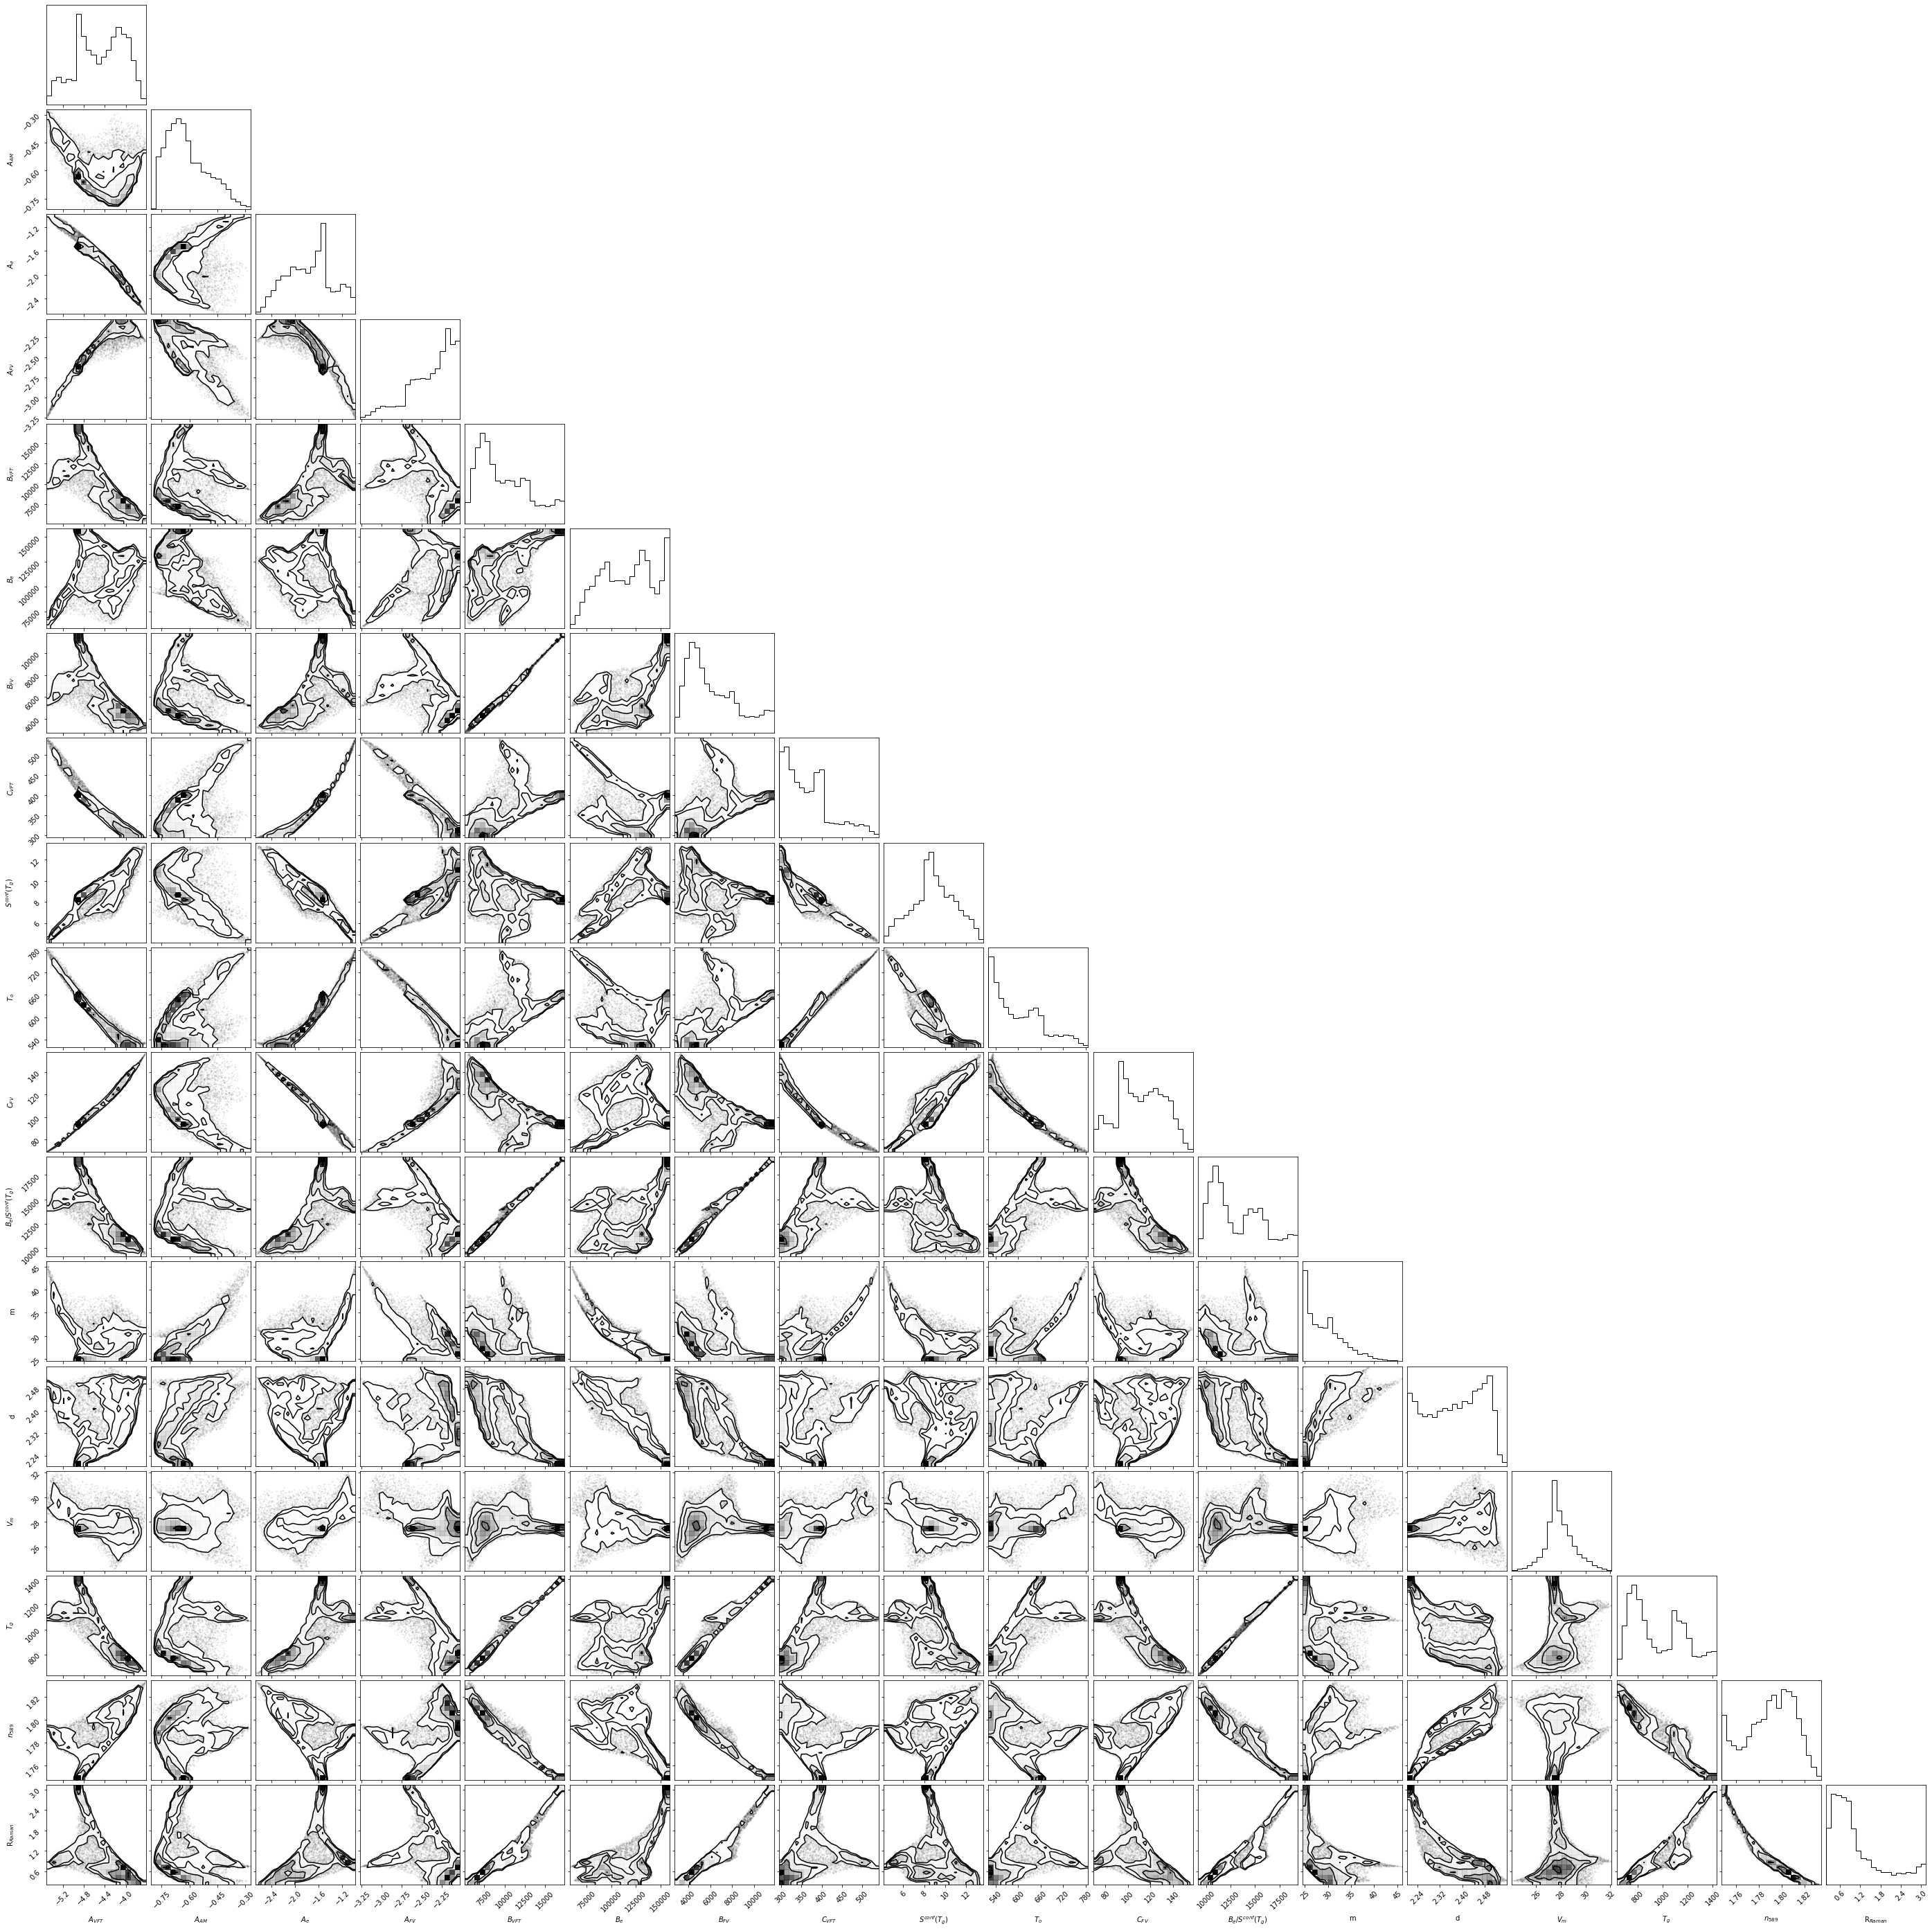

In [10]:
plt.figure(figsize=(15,15))
corner.corner(samples, labels=labels);

# Figure 7: maps of glass properties: Tg, density, refractive index

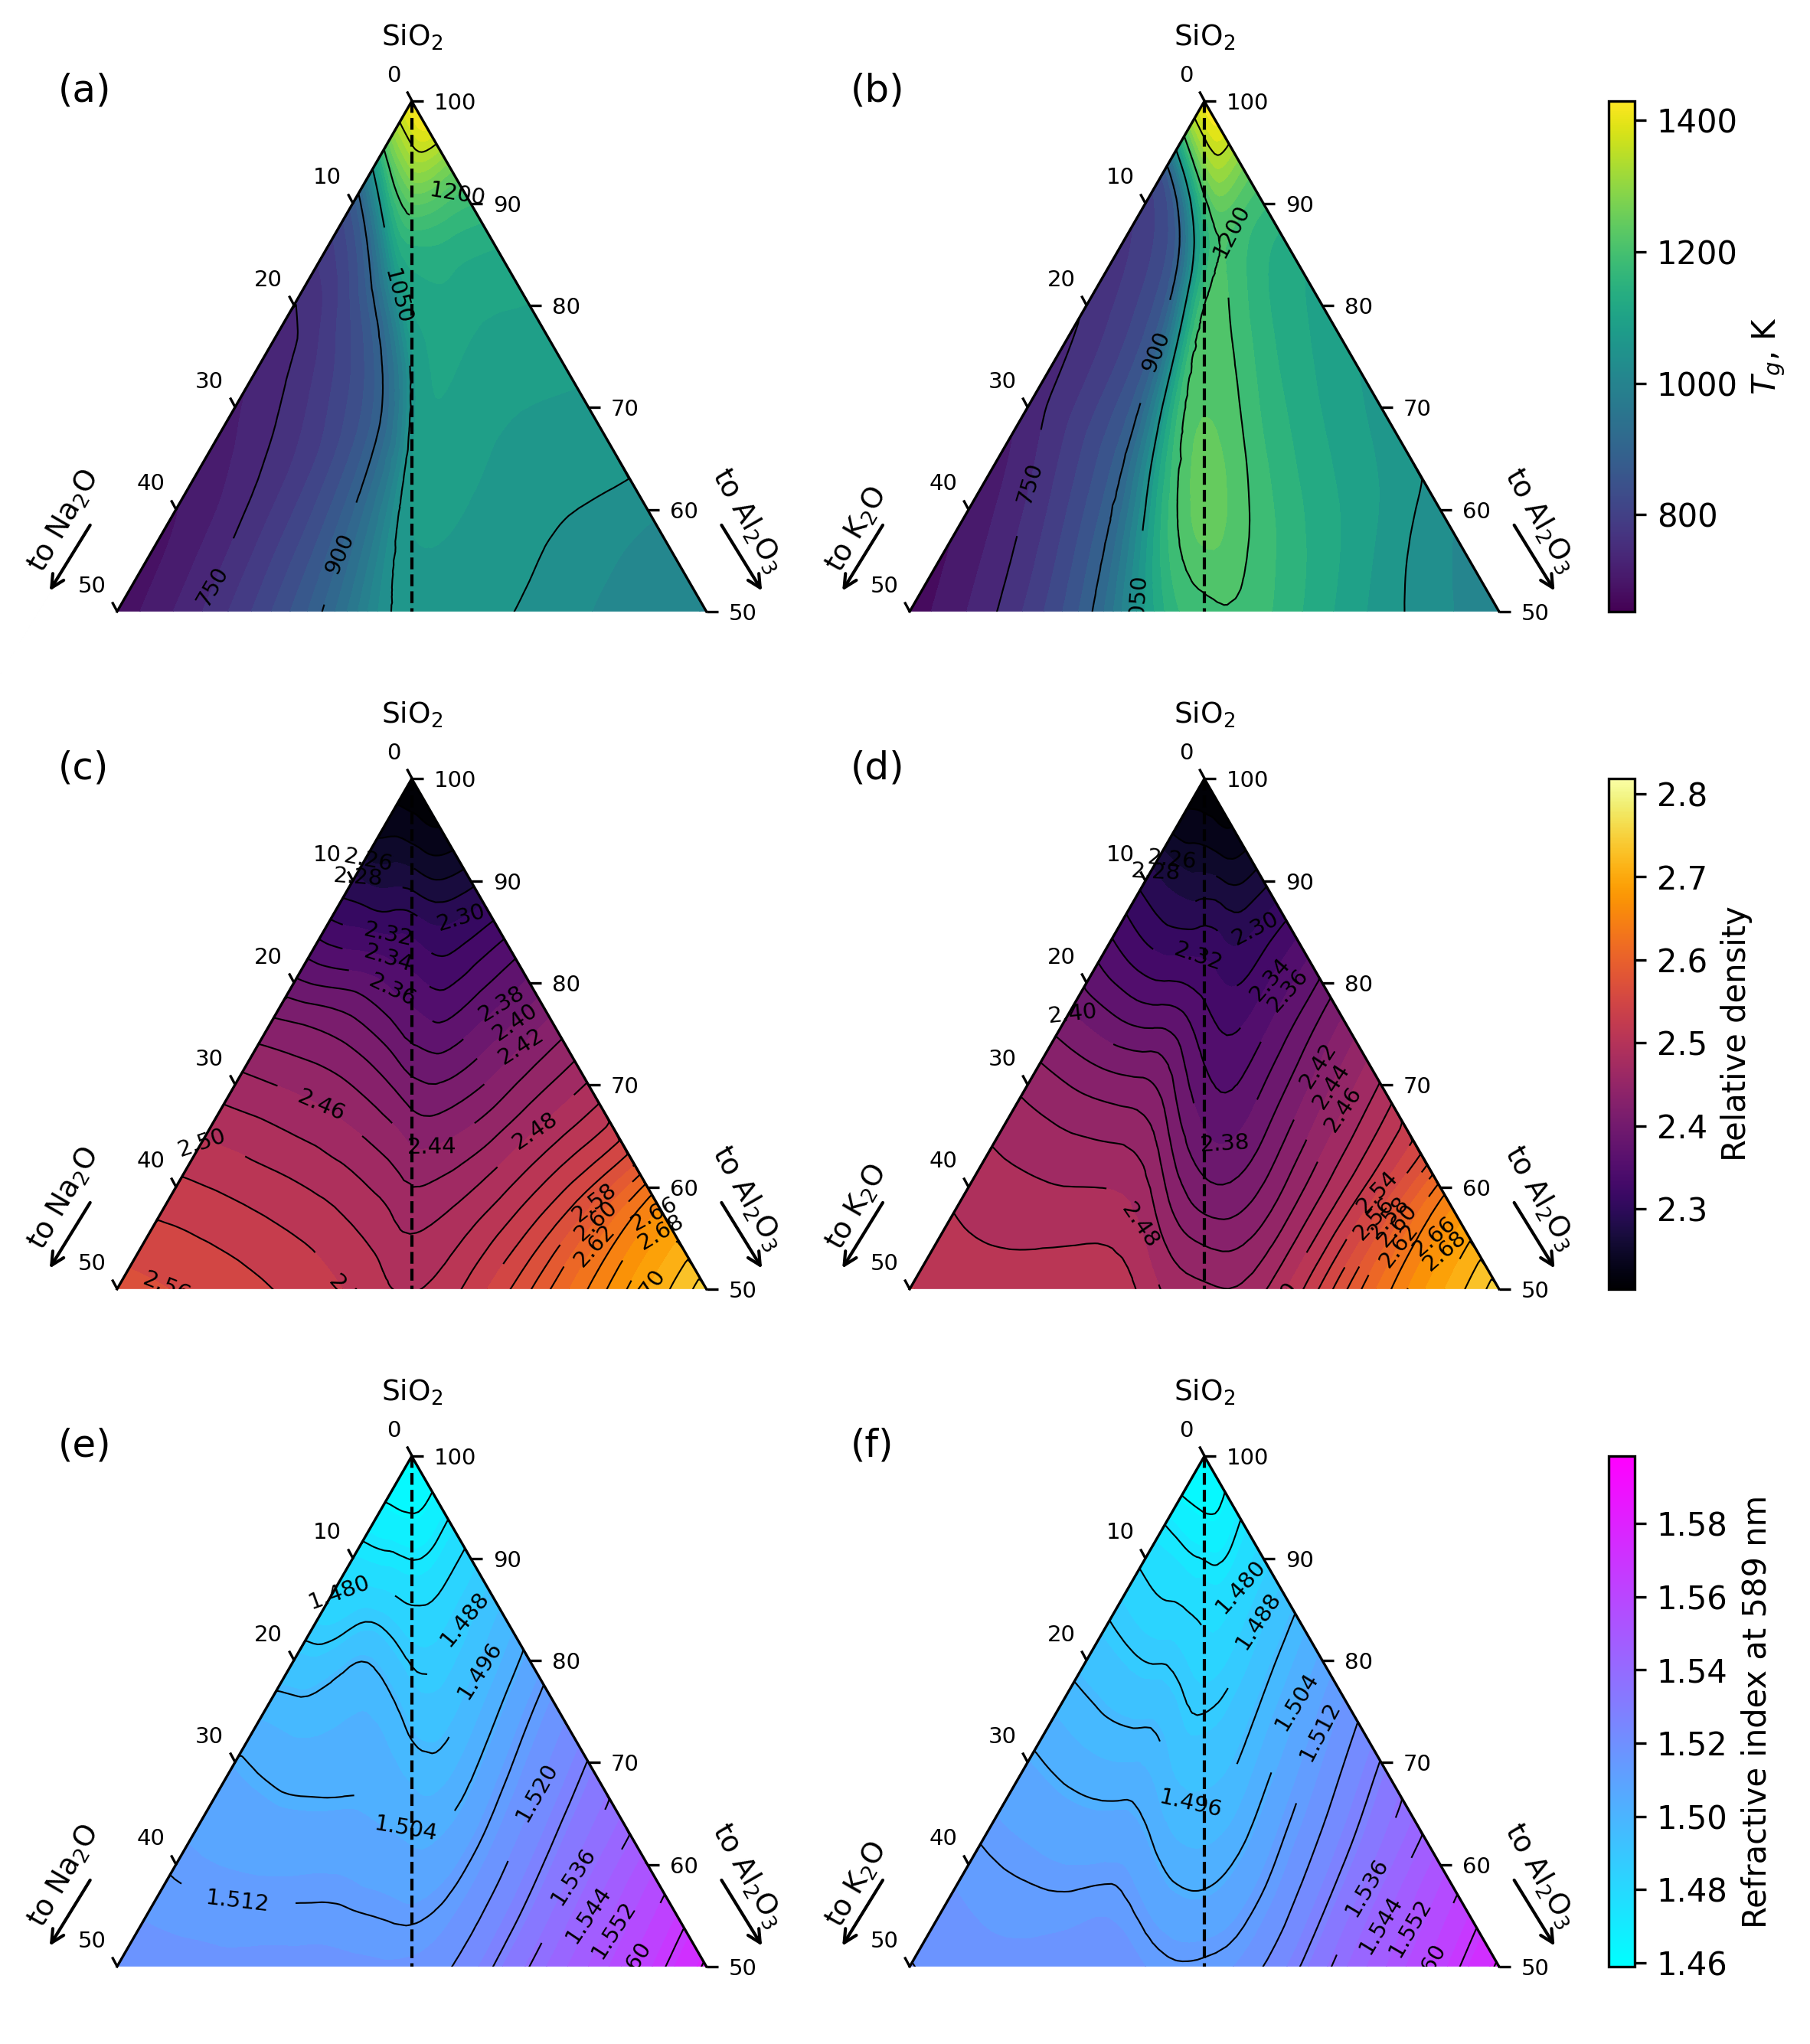

In [11]:
plt.figure(figsize=(9,9), dpi=300)

# grabing the predictions in NAS and KAS
tg_NAS = neuralmodel.predict("tg",X_gen_NAS).mean(axis=1)
tg_KAS = neuralmodel.predict("tg",X_gen_KAS).mean(axis=1)
tg_all = neuralmodel.predict("tg",X_gen_all).mean(axis=1)

d_NAS = neuralmodel.predict("density",X_gen_NAS).mean(axis=1)
d_KAS = neuralmodel.predict("density",X_gen_KAS).mean(axis=1)
d_all = neuralmodel.predict("density",X_gen_all).mean(axis=1)

n_NAS = neuralmodel.predict("sellmeier",X_gen_NAS,lbd=np.ones((len(X_gen_NAS),1))*0.589).mean(axis=1)
n_KAS = neuralmodel.predict("sellmeier",X_gen_KAS,lbd=np.ones((len(X_gen_KAS),1))*0.589).mean(axis=1)
n_all = neuralmodel.predict("sellmeier",X_gen_all,lbd=np.ones((len(X_gen_all),1))*0.589).mean(axis=1)

# choose colormaps
c_m1 = matplotlib.cm.viridis 
c_m2 = matplotlib.cm.inferno 
c_m3 = matplotlib.cm.cool 

# color normalisation
norm1 = matplotlib.colors.Normalize(vmin=np.min(tg_all), vmax=np.max(tg_all))
norm2 = matplotlib.colors.Normalize(vmin=np.min(d_all), vmax=np.max(d_all))
norm3 = matplotlib.colors.Normalize(vmin=np.min(n_all), vmax=np.max(n_all))

#### Scalar Mappables for color bars
s_tg = matplotlib.cm.ScalarMappable(cmap=c_m1, 
                                   norm=norm1) # create a ScalarMappable and initialize a data structure
s_d = matplotlib.cm.ScalarMappable(cmap=c_m2, 
                                   norm=norm2)
s_n = matplotlib.cm.ScalarMappable(cmap=c_m3, 
                                   norm=norm3)

#### Levels

levels_tg = np.arange(500,1500,100)
levels_tg_write = [700, 900, 1100]
levels_d = np.arange(2.2,2.8,0.02)
levels_n = np.arange(1.3,1.9,0.01)

####
#### NAS Tg TERNARY PLOT
####
ax = plt.subplot(3,2,1,projection='ternary', ternary_scale=100)

tc = ax.tricontourf(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                tg_NAS, 
                levels=30, cmap=c_m1, norm=norm1)

tc = ax.tricontour(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                tg_NAS, 
                levels=6, colors="k", norm=norm1, linewidths=0.5)

ax.clabel(tc, inline=1, fontsize=7, fmt="%1.0f")

ax.set_tlabel('SiO$_2$', fontsize = 9)
imelt.make_arrow(ax, 'to Na$_2$O', 'to Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax.tick_params(labelrotation='horizontal')

####
#### KAS Tg TERNARY PLOT
####
ax2 = plt.subplot(3,2,2,projection='ternary', ternary_scale=100)

tc2 = ax2.tricontourf(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                tg_KAS, 
                levels=30, cmap=c_m1, norm=norm1)

tc2 = ax2.tricontour(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                tg_KAS, 
                levels=6, colors="k", norm=norm1, linewidths=0.5)

ax2.clabel(tc2, inline=1, fontsize=7, fmt="%1.0f")

ax2.set_tlabel('SiO$_2$', fontsize = 9)
imelt.make_arrow(ax2, 'to K$_2$O', 'to Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax2.tick_params(labelrotation='horizontal')

####
#### NAS Density TERNARY PLOT
####
ax3 = plt.subplot(3,2,3,projection='ternary', ternary_scale=100)

ax3.tricontourf(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                d_NAS, 
                levels=30, cmap=c_m2, norm=norm2)

tc3 = ax3.tricontour(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                d_NAS, 
                levels=levels_d, colors="k", norm=norm2, linewidths=0.5)

ax3.clabel(tc3, inline=1, fontsize=7, fmt="%1.2f")

ax3.set_tlabel('SiO$_2$', fontsize = 9)
imelt.make_arrow(ax3, 'to Na$_2$O', 'to Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax3.tick_params(labelrotation='horizontal')

####
#### KAS Density TERNARY PLOT
####
ax4 = plt.subplot(3,2,4,projection='ternary', ternary_scale=100)

ax4.tricontourf(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                d_KAS, 
                levels=30, cmap=c_m2, norm=norm2)

tc4 = ax4.tricontour(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                d_KAS, 
                levels=levels_d, colors="k", norm=norm2, linewidths=0.5)

ax4.clabel(tc4, inline=1, fontsize=7, fmt="%1.2f")

ax4.set_tlabel('SiO$_2$', fontsize = 9)
imelt.make_arrow(ax4, 'to K$_2$O', 'to Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax4.tick_params(labelrotation='horizontal')

####
#### NAS Refractive Index TERNARY PLOT
####
ax5 = plt.subplot(3,2,5,projection='ternary', ternary_scale=100)

# data are plotted
ax5.tricontourf(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                n_NAS, 
                levels=30, cmap=c_m3, norm=norm3)

tc5 = ax5.tricontour(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                n_NAS, 
                levels=20, colors="k", norm=norm3, linewidths=0.5)
ax5.clabel(tc5, inline=1, fontsize=7, fmt="%1.3f")

ax5.set_tlabel('SiO$_2$', fontsize = 9)
imelt.make_arrow(ax5, 'to Na$_2$O', 'to Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax5.tick_params(labelrotation='horizontal')

####
#### KAS Refractive Index TERNARY PLOT
####
ax6 = plt.subplot(3,2,6,projection='ternary', ternary_scale=100)

# data are plotted
ax6.tricontourf(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                n_KAS, 
                levels=30, cmap=c_m3, norm=norm3)

tc6 = ax6.tricontour(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                n_KAS, 
                levels=20, colors="k", norm=norm3, linewidths=0.5)

ax6.clabel(tc6, inline=1, fontsize=7, fmt="%1.3f")

ax6.set_tlabel('SiO$_2$', fontsize = 9)
imelt.make_arrow(ax6, 'to K$_2$O', 'to Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax6.tick_params(labelrotation='horizontal')

####
#### Limits (see previous examples)
#### tmin, tmax, lmin, lmax, rmin, rmax
####
ax.set_ternary_lim(50, 100, 0.0, 50,0.0, 50)
ax2.set_ternary_lim(50, 100, 0.0, 50,0.0, 50)
ax3.set_ternary_lim(50, 100, 0.0, 50,0.0, 50)
ax4.set_ternary_lim(50, 100, 0.0, 50,0.0, 50)
ax5.set_ternary_lim(50, 100, 0.0, 50,0.0, 50)
ax6.set_ternary_lim(50, 100, 0.0, 50,0.0, 50)

####
#### Annotations
####
ax.annotate("(a)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)
ax2.annotate("(b)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)
ax3.annotate("(c)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)
ax4.annotate("(d)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)
ax5.annotate("(e)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)
ax6.annotate("(f)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)

####
#### ticks size
####
ax.tick_params(labelsize=7)
ax2.tick_params(labelsize=7)
ax3.tick_params(labelsize=7)
ax4.tick_params(labelsize=7)
ax5.tick_params(labelsize=7)
ax6.tick_params(labelsize=7)

ax.raxis.set_ticks([])
ax2.raxis.set_ticks([])
ax3.raxis.set_ticks([])
ax4.raxis.set_ticks([])
ax5.raxis.set_ticks([])
ax6.raxis.set_ticks([])

###
### plot tectosilicate join
###
ax.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)
ax2.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)
ax3.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)
ax4.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)
ax5.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)
ax6.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)

####
#### Remove bottom axis
####
ax.spines['tside'].set_visible(False)
ax2.spines['tside'].set_visible(False)
ax3.spines['tside'].set_visible(False)
ax4.spines['tside'].set_visible(False)
ax5.spines['tside'].set_visible(False)
ax6.spines['tside'].set_visible(False)


####
#### tight layout
####

plt.tight_layout(w_pad=1.)

####
#### Colorbar for the two subplots
####
cbar_1 = plt.colorbar(mappable=s_tg,ax=[ax,ax2],orientation="vertical",pad=0.055)
cbar_1.set_label(r"$T_g$, K")

cbar_2 = plt.colorbar(mappable=s_d,ax=[ax3,ax4],orientation="vertical",pad=0.055)
cbar_2.set_label(r"Relative density")

cbar_3 = plt.colorbar(mappable=s_n,ax=[ax5,ax6],orientation="vertical",pad=0.055)
cbar_3.set_label(r"Refractive index at 589 nm")


plt.savefig("./figures/Figure7_Tg_maps.pdf",bbox_inches='tight')

# Figure 8: melt fragility

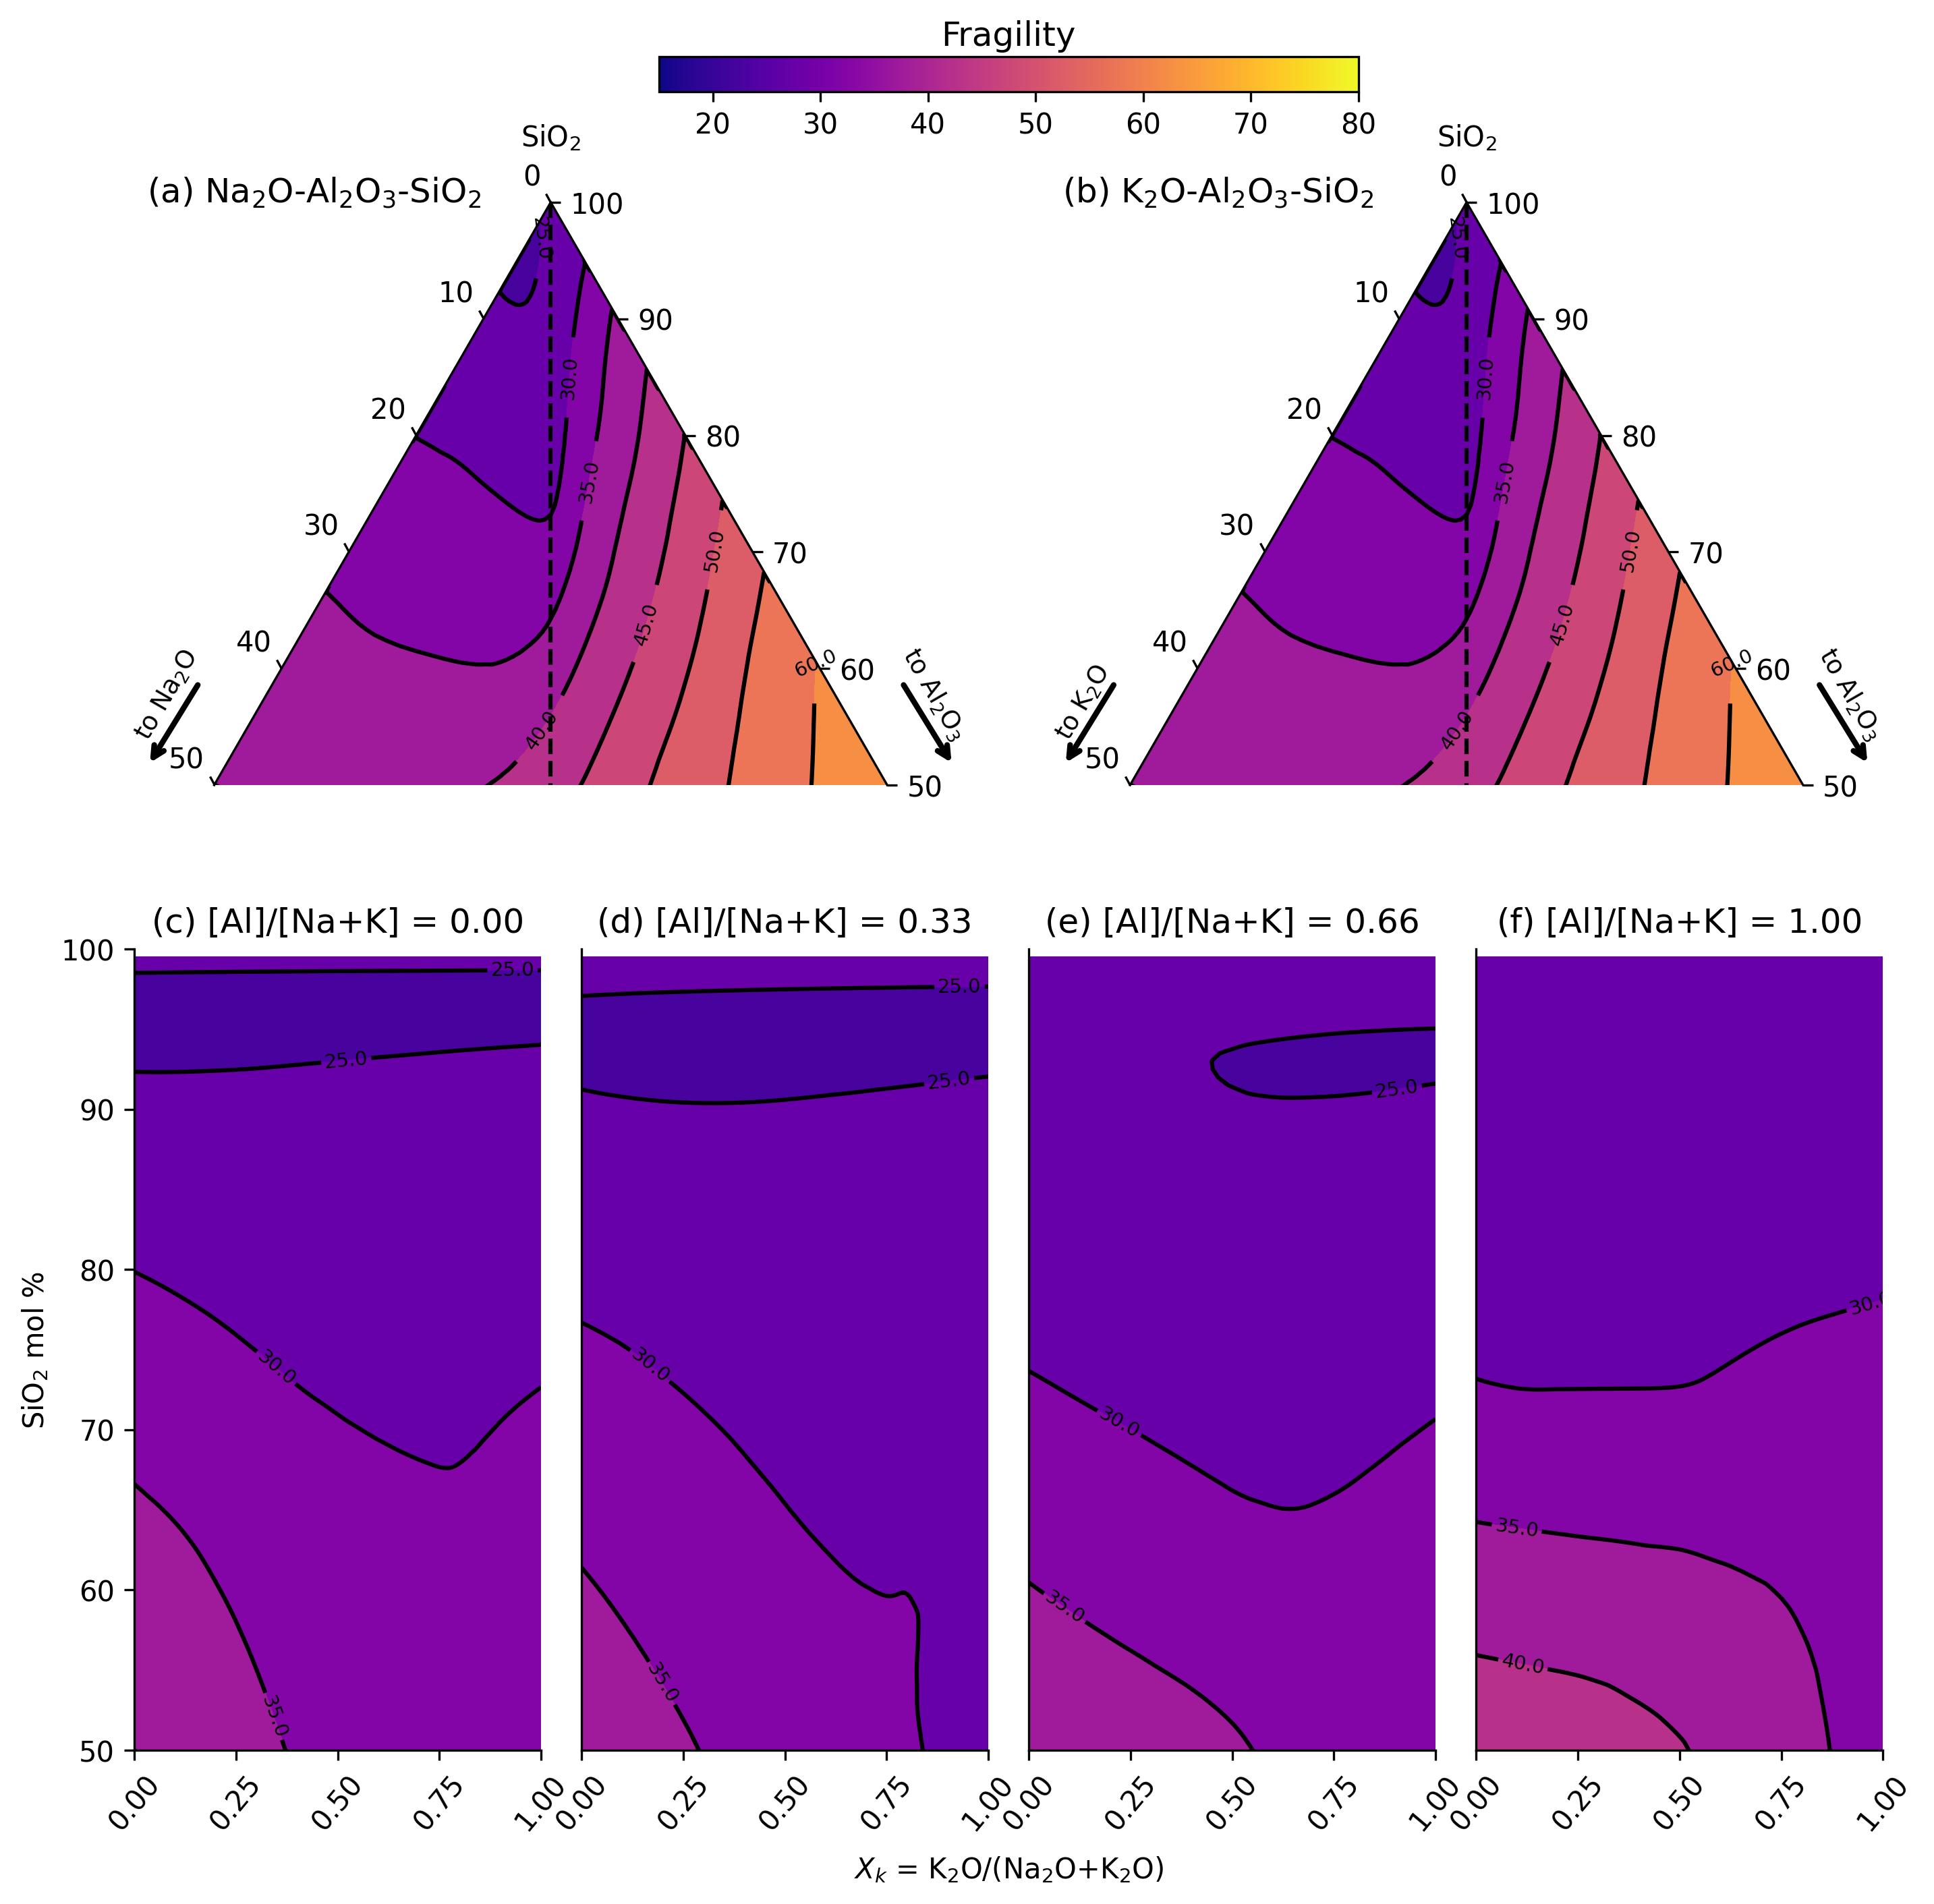

In [12]:
#APV: Added lines to contour plots for clarity
#     Increased levels for smoothness
#     Minor tweaks to layout
#     Wonder if colourbar limits should be changed to be integers for better labeling?

####
#### GENERATING ENTROPY
####

# grabing the entropies along NS/KS
fragility_NAS = neuralmodel.predict("fragility",X_gen_NAS).mean(axis=1)
fragility_KAS = neuralmodel.predict("fragility",X_gen_KAS).mean(axis=1)
fragility_all = neuralmodel.predict("fragility",X_gen_all).mean(axis=1)

# grabing the entropies for the mixtures
fragility_RS_Xk = neuralmodel.predict("fragility",X_gen_RS_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
fragility_R3_Xk = neuralmodel.predict("fragility",X_gen_R3_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
fragility_R2_Xk = neuralmodel.predict("fragility",X_gen_R2_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
fragility_R1_Xk = neuralmodel.predict("fragility",X_gen_R1_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)

####
#### COLOR CALCULATIONS
####

trig_color_plot = fragility_all # for the colors > same scale 

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=15.0,
    vmax=80.0) # Manual setup

c_m = matplotlib.cm.plasma # choose a colormap
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm) # create a ScalarMappable and initialize a data structure

####
#### FIGURE DECLARATION
#### gridspec is used for a finer control
####

fig11 = plt.figure(figsize=(9,9),dpi=300, constrained_layout=False)

gs1 = fig11.add_gridspec(nrows=1, ncols=2, 
                        left=0.02, right=0.98,
                        bottom = 0.55, top = 0.95,
                        wspace=0.1)
ax = fig11.add_subplot(gs1[0],projection='ternary',ternary_scale = 100)
ax2 = fig11.add_subplot(gs1[1],projection='ternary', ternary_scale = 100)

gs2 = fig11.add_gridspec(nrows=1, ncols=4, 
                        left=0.02, right=0.98,
                        bottom = 0.02, top = 0.46,
                        wspace=0.1)
ax3 = fig11.add_subplot(gs2[0,0])
ax5 = fig11.add_subplot(gs2[0,1])
ax6 = fig11.add_subplot(gs2[0,2])
ax4 = fig11.add_subplot(gs2[0,3])

####
#### TERNARY PLOT NAS
####
levels = np.arange(15,80,5)
levels_l = np.arange(15,80,5)

imelt.make_ternary(ax, 
             X_gen_NAS_rec.sio2, X_gen_NAS_rec.na2o, X_gen_NAS_rec.al2o3,fragility_NAS,
             'SiO$_2$', 'to Na$_2$O', 'to Al$_2$O$_3$',
            levels, levels_l, c_m, norm,
             [50,100],
            annotation = "(a) Na$_2$O-Al$_2$O$_3$-SiO$_2$")

####
#### TERNARY PLOT KAS
####

imelt.make_ternary(ax2, 
             X_gen_KAS_rec.sio2, X_gen_KAS_rec.k2o, X_gen_KAS_rec.al2o3,fragility_NAS,
             'SiO$_2$', 'to K$_2$O', 'to Al$_2$O$_3$',
            levels, levels_l, c_m, norm,
             [50,100],
            annotation = "(b) K$_2$O-Al$_2$O$_3$-SiO$_2$")

####
#### XK along near tectosilicate joint
####

tc3 = ax3.tricontourf(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"]*100, 
                fragility_RS_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc3_l = ax3.tricontour(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"]*100, 
                fragility_RS_Xk, 
                levels=levels_l, colors='k', norm=norm)
ax3.clabel(tc3_l, inline=1, fontsize=7, fmt="%1.1f")

ax3.set_xlim(0,1)
ax3.set_ylim(50,100.)

ax3.set_ylabel(r"SiO$_2$ mol %")

# Hide the right and top spines
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

# Title
ax3.set_title("(c) [Al]/[Na+K] = 0.00", loc='center')

####
#### XK along near join 3
####

tc5 = ax5.tricontourf(X_gen_R3_Xk_rec.loc[:,"xk"], 
                X_gen_R3_Xk_rec.loc[:,"sio2"]*100, 
                fragility_R3_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc5_l = ax5.tricontour(X_gen_R3_Xk_rec.loc[:,"xk"], 
                X_gen_R3_Xk_rec.loc[:,"sio2"]*100, 
                fragility_R3_Xk, 
                levels=levels_l, colors='black', norm=norm)
ax5.clabel(tc5_l, inline=1, fontsize=7, fmt="%1.1f")

ax5.set_xlim(0,1.)
ax5.set_ylim(50,100.)

# Hide the right and top spines
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

# Title
ax5.set_title("(d) [Al]/[Na+K] = 0.33", loc='center')

####
#### XK along near join 2
####
tc6 = ax6.tricontourf(X_gen_R2_Xk_rec.loc[:,"xk"], 
                X_gen_R2_Xk_rec.loc[:,"sio2"]*100, 
                fragility_R2_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc6_l = ax6.tricontour(X_gen_R2_Xk_rec.loc[:,"xk"], 
                X_gen_R2_Xk_rec.loc[:,"sio2"]*100, 
                fragility_R2_Xk, 
                levels=levels_l, colors='black', norm=norm)
ax6.clabel(tc6_l, inline=1, fontsize=7, fmt="%1.1f")

ax6.set_xlim(0,1.)
ax6.set_ylim(50,100.)

# Hide the right and top spines
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)

# Title
ax6.set_title("(e) [Al]/[Na+K] = 0.66", loc='center')

####
#### XK along near tectosilicate joint
####

tc4 = ax4.tricontourf(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"]*100, 
                fragility_R1_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc4 = ax4.tricontour(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"]*100, 
                fragility_R1_Xk, 
                levels=levels_l, colors='black', norm=norm)

ax4.clabel(tc4, inline=1, fontsize=7, fmt="%1.1f")

ax4.set_xlim(0,1.)
ax4.set_ylim(50,100.)

# Hide the right and top spines
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

# Title
ax4.set_title("(f) [Al]/[Na+K] = 1.00", loc='center')

####
#### Layout adjustment ; most things are done above in gridspec so no need to add tight_layout()
####

# remove y ticks on bottom subplots
ax4.set_yticks([])
ax5.set_yticks([])
ax6.set_yticks([])

# rotate xticks
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=50 )
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=50 )
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=50 )
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=50 )

# common X labels
fig11.text(0.5, -0.05, r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)", ha='center')

####
#### colorbar
####

cbar_0 = plt.colorbar(mappable=s_m, ax=[ax,ax2],shrink=0.4,location='top',anchor=(0.5,1.0))
cbar_0.set_label(r"Fragility", fontsize=12)
cbar_0.ax.xaxis.set_label_position('top')
cbar_0.ax.xaxis.set_ticks_position('bottom')

plt.savefig("./figures/Figure8_Fragility.pdf",bbox_inches="tight")


# Figure 9 : configurational entropy

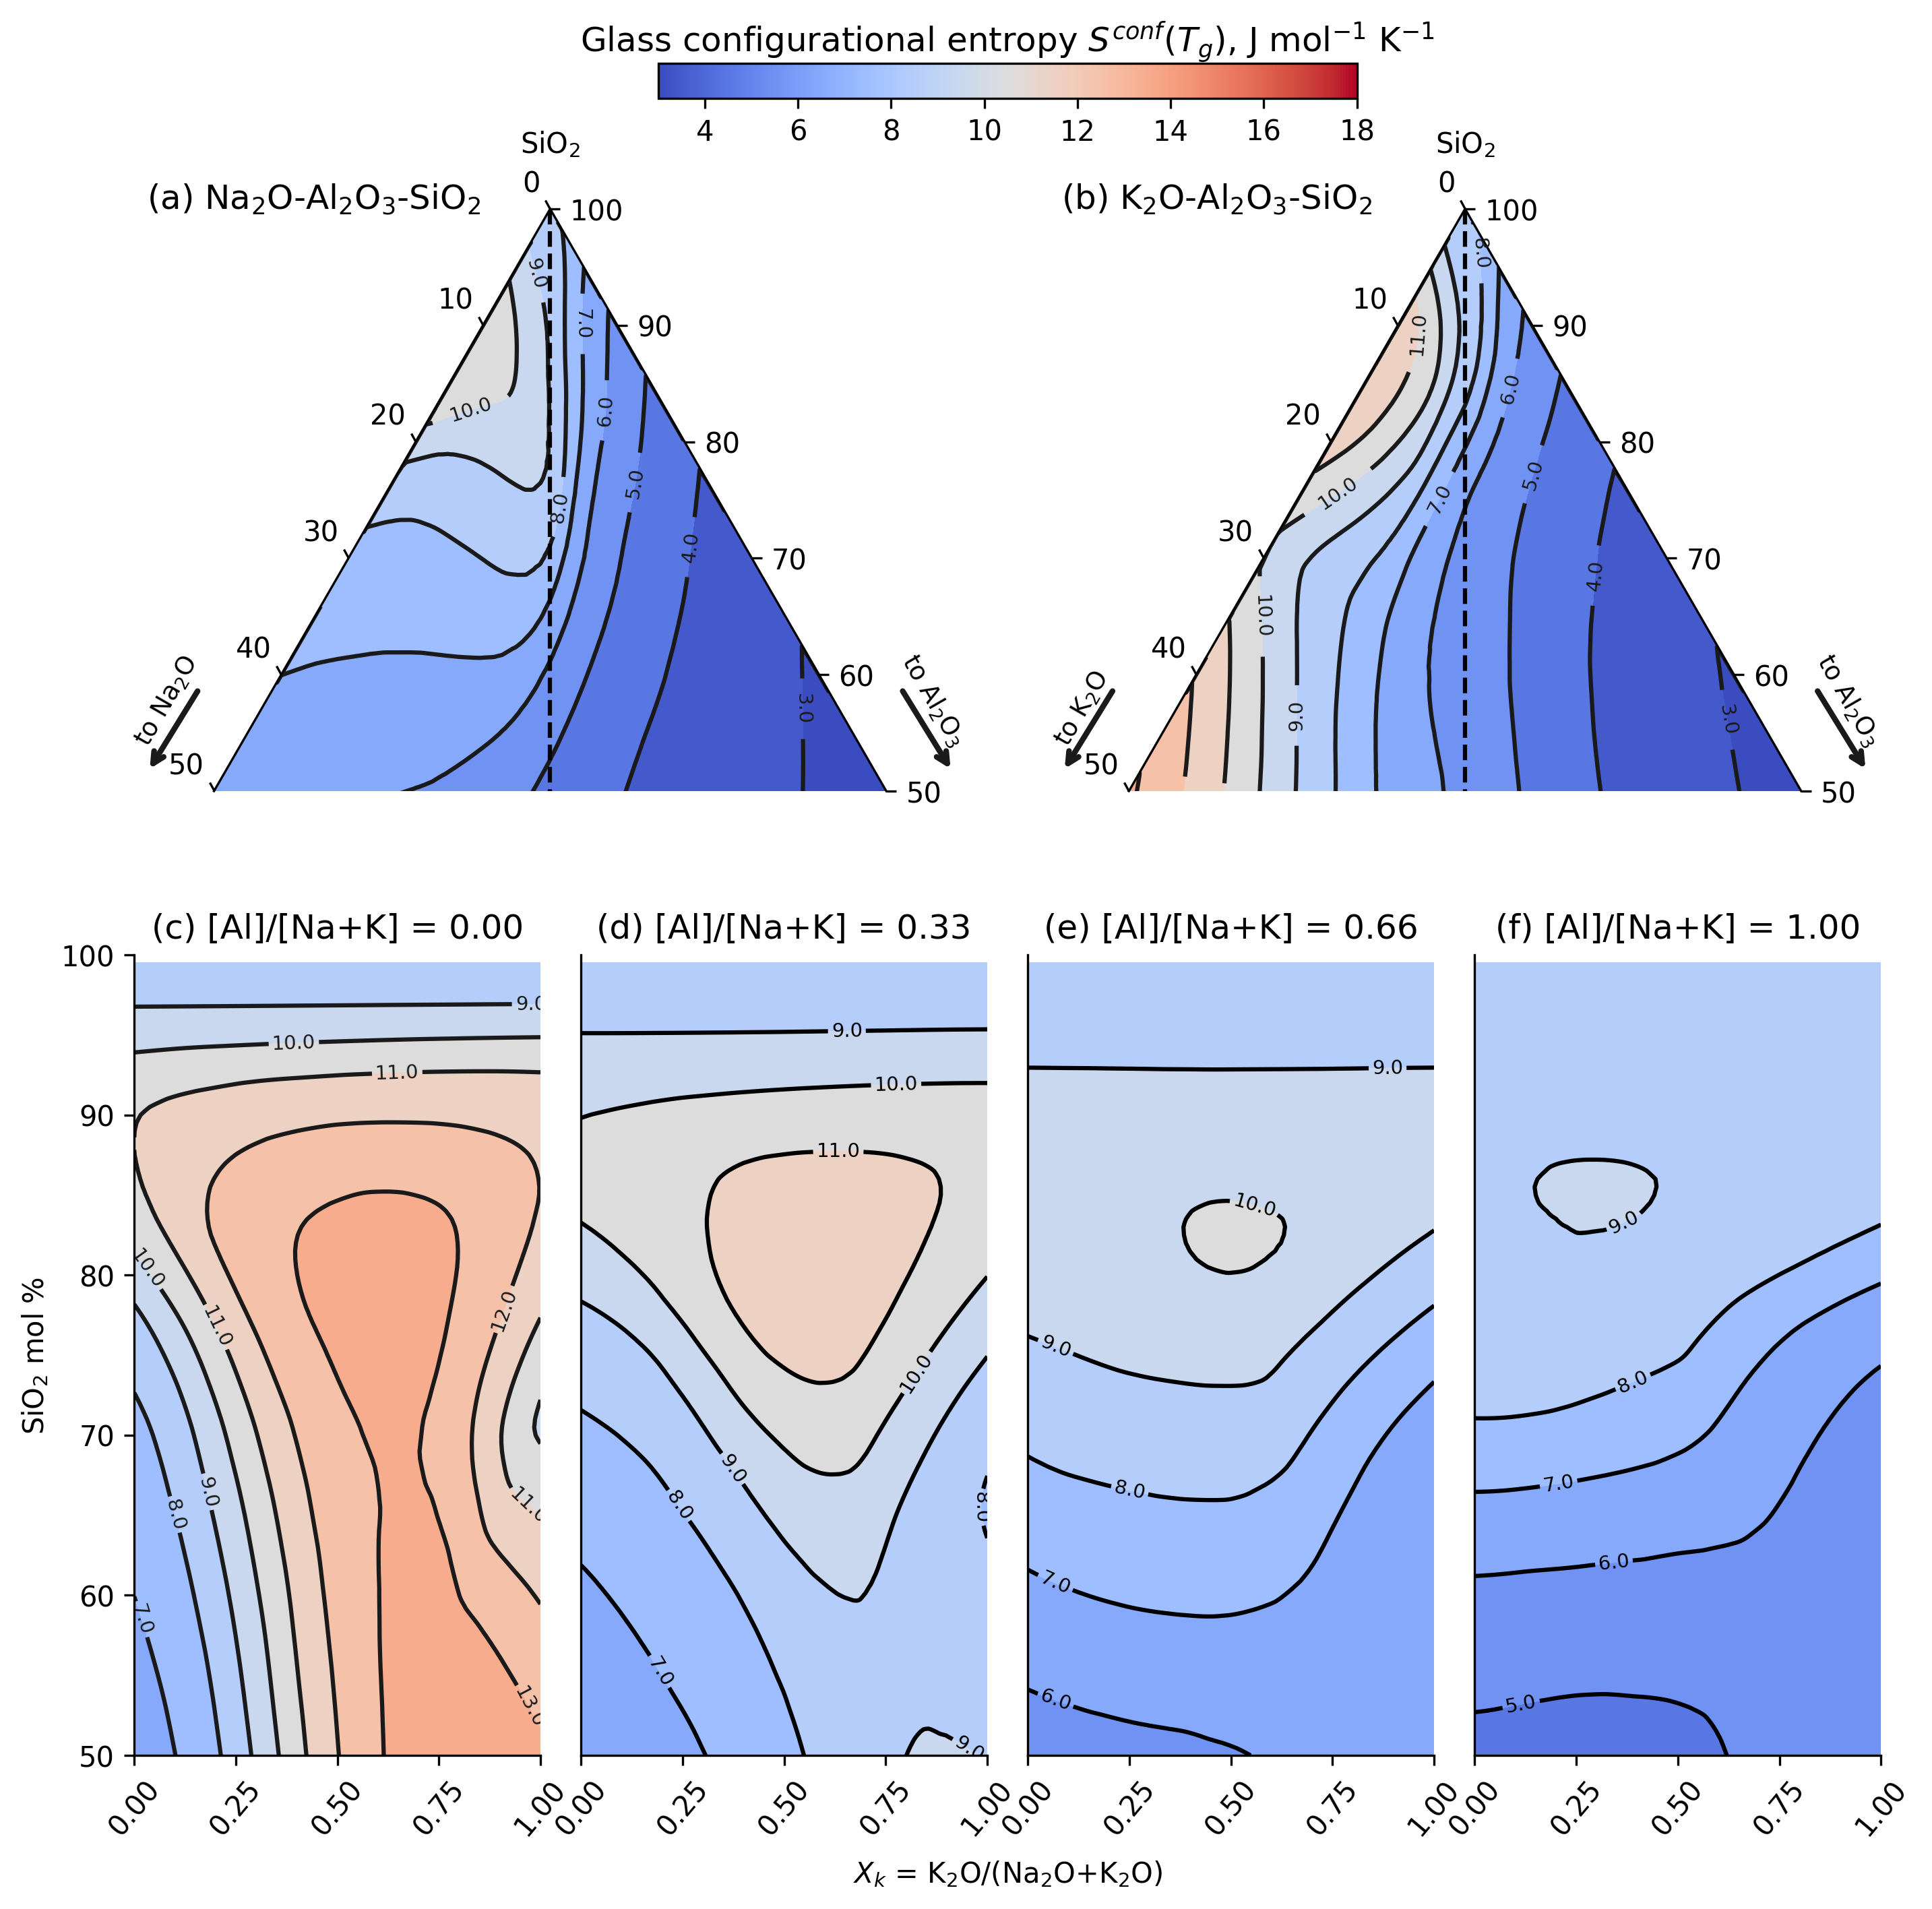

In [22]:
#APV: Added lines to contour plots for clarity
#     Increased levels for smoothness
#     Minor tweaks to layout
#     Wonder if colourbar limits should be changed to be integers for better labeling?

####
#### GENERATING ENTROPY
####

# grabing the entropies along NS/KS
sctg_NAS = neuralmodel.predict("sctg",X_gen_NAS).mean(axis=1)
sctg_KAS = neuralmodel.predict("sctg",X_gen_KAS).mean(axis=1)
sctg_all = neuralmodel.predict("sctg",X_gen_all).mean(axis=1)

# grabing the entropies for the mixtures
sctg_RS_Xk = neuralmodel.predict("sctg",X_gen_RS_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
sctg_R3_Xk = neuralmodel.predict("sctg",X_gen_R3_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
sctg_R2_Xk = neuralmodel.predict("sctg",X_gen_R2_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
sctg_R1_Xk = neuralmodel.predict("sctg",X_gen_R1_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)

####
#### COLOR CALCULATIONS
####

trig_color_plot = sctg_all # for the colors > same scale 

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=3.0,
    vmax=18.0) # Manual setup

c_m = matplotlib.cm.coolwarm # choose a colormap
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm) # create a ScalarMappable and initialize a data structure

####
#### FIGURE DECLARATION
#### gridspec is used for a finer control
####

fig9 = plt.figure(figsize=(9,9),dpi=300, constrained_layout=False)

gs1 = fig9.add_gridspec(nrows=1, ncols=2, 
                        left=0.02, right=0.98,
                        bottom = 0.55, top = 0.95,
                        wspace=0.1)
ax = fig9.add_subplot(gs1[0],projection='ternary',ternary_scale=100)
ax2 = fig9.add_subplot(gs1[1],projection='ternary',ternary_scale=100)

gs2 = fig9.add_gridspec(nrows=1, ncols=4, 
                        left=0.02, right=0.98,
                        bottom = 0.02, top = 0.46,
                        wspace=0.1)
ax3 = fig9.add_subplot(gs2[0,0])
ax5 = fig9.add_subplot(gs2[0,1])
ax6 = fig9.add_subplot(gs2[0,2])
ax4 = fig9.add_subplot(gs2[0,3])

####
#### TERNARY PLOT NAS
####
levels = np.arange(2,18,1)
levels_l = np.arange(2,18,1)

imelt.make_ternary(ax, 
             X_gen_NAS_rec.sio2, X_gen_NAS_rec.na2o, X_gen_NAS_rec.al2o3,sctg_NAS,
             'SiO$_2$', 'to Na$_2$O', 'to Al$_2$O$_3$',
            levels, levels_l, c_m, norm,
             [50,100],
            annotation = "(a) Na$_2$O-Al$_2$O$_3$-SiO$_2$")

####
#### TERNARY PLOT KAS
####

imelt.make_ternary(ax2, 
             X_gen_KAS_rec.sio2, X_gen_KAS_rec.k2o, X_gen_KAS_rec.al2o3,sctg_KAS,
             'SiO$_2$', 'to K$_2$O', 'to Al$_2$O$_3$',
            levels, levels_l, c_m, norm,
             [50,100],
            annotation = "(b) K$_2$O-Al$_2$O$_3$-SiO$_2$")

####
#### XK along near tectosilicate joint
####

tc3 = ax3.tricontourf(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"]*100, 
                sctg_RS_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc3_l = ax3.tricontour(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"]*100, 
                sctg_RS_Xk, 
                levels=levels_l, colors='k', norm=norm)
ax3.clabel(tc3_l, inline=1, fontsize=7, fmt="%1.1f")

ax3.set_xlim(0,1)
ax3.set_ylim(50,100.)

ax3.set_ylabel(r"SiO$_2$ mol %")

# Hide the right and top spines
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

# Title
ax3.set_title("(c) [Al]/[Na+K] = 0.00", loc='center')

####
#### XK along near join 3
####

tc5 = ax5.tricontourf(X_gen_R3_Xk_rec.loc[:,"xk"], 
                X_gen_R3_Xk_rec.loc[:,"sio2"]*100, 
                sctg_R3_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc5_l = ax5.tricontour(X_gen_R3_Xk_rec.loc[:,"xk"], 
                X_gen_R3_Xk_rec.loc[:,"sio2"]*100, 
                sctg_R3_Xk, 
                levels=levels_l, colors='black', norm=norm)
ax5.clabel(tc5_l, inline=1, fontsize=7, fmt="%1.1f")

ax5.set_xlim(0,1.)
ax5.set_ylim(50,100.)

# Hide the right and top spines
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

# Title
ax5.set_title("(d) [Al]/[Na+K] = 0.33", loc='center')

####
#### XK along near join 2
####
tc6 = ax6.tricontourf(X_gen_R2_Xk_rec.loc[:,"xk"], 
                X_gen_R2_Xk_rec.loc[:,"sio2"]*100, 
                sctg_R2_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc6_l = ax6.tricontour(X_gen_R2_Xk_rec.loc[:,"xk"], 
                X_gen_R2_Xk_rec.loc[:,"sio2"]*100, 
                sctg_R2_Xk, 
                levels=levels_l, colors='black', norm=norm)
ax6.clabel(tc6_l, inline=1, fontsize=7, fmt="%1.1f")

ax6.set_xlim(0,1.)
ax6.set_ylim(50,100.)

# Hide the right and top spines
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)

# Title
ax6.set_title("(e) [Al]/[Na+K] = 0.66", loc='center')

####
#### XK along near tectosilicate joint
####

tc4 = ax4.tricontourf(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"]*100, 
                sctg_R1_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc4 = ax4.tricontour(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"]*100, 
                sctg_R1_Xk, 
                levels=levels_l, colors='black', norm=norm)

ax4.clabel(tc4, inline=1, fontsize=7, fmt="%1.1f")

ax4.set_xlim(0,1.)
ax4.set_ylim(50,100.)

# Hide the right and top spines
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

# Title
ax4.set_title("(f) [Al]/[Na+K] = 1.00", loc='center')

####
#### Layout adjustment ; most things are done above in gridspec so no need to add tight_layout()
####

# remove y ticks on bottom subplots
ax4.set_yticks([])
ax5.set_yticks([])
ax6.set_yticks([])

# rotate xticks
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=50 )
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=50 )
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=50 )
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=50 )

# common X labels
fig9.text(0.5, -0.05, r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)", ha='center')

####
#### colorbar
####

cbar_0 = plt.colorbar(mappable=s_m, ax=[ax,ax2],shrink=0.4,location='top',anchor=(0.5,1.0))
cbar_0.set_label(r"Glass configurational entropy $S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$", fontsize=12)
cbar_0.ax.xaxis.set_label_position('top')
cbar_0.ax.xaxis.set_ticks_position('bottom')

plt.savefig("./figures/Figure9_entromaps.pdf",bbox_inches="tight")


# Figure 10: structure and property links

['$n_{589}$', '$B_e/S^{conf}(T_g)$', '$B_{CG}$', '$T_g$', 'R$_{Raman}$']


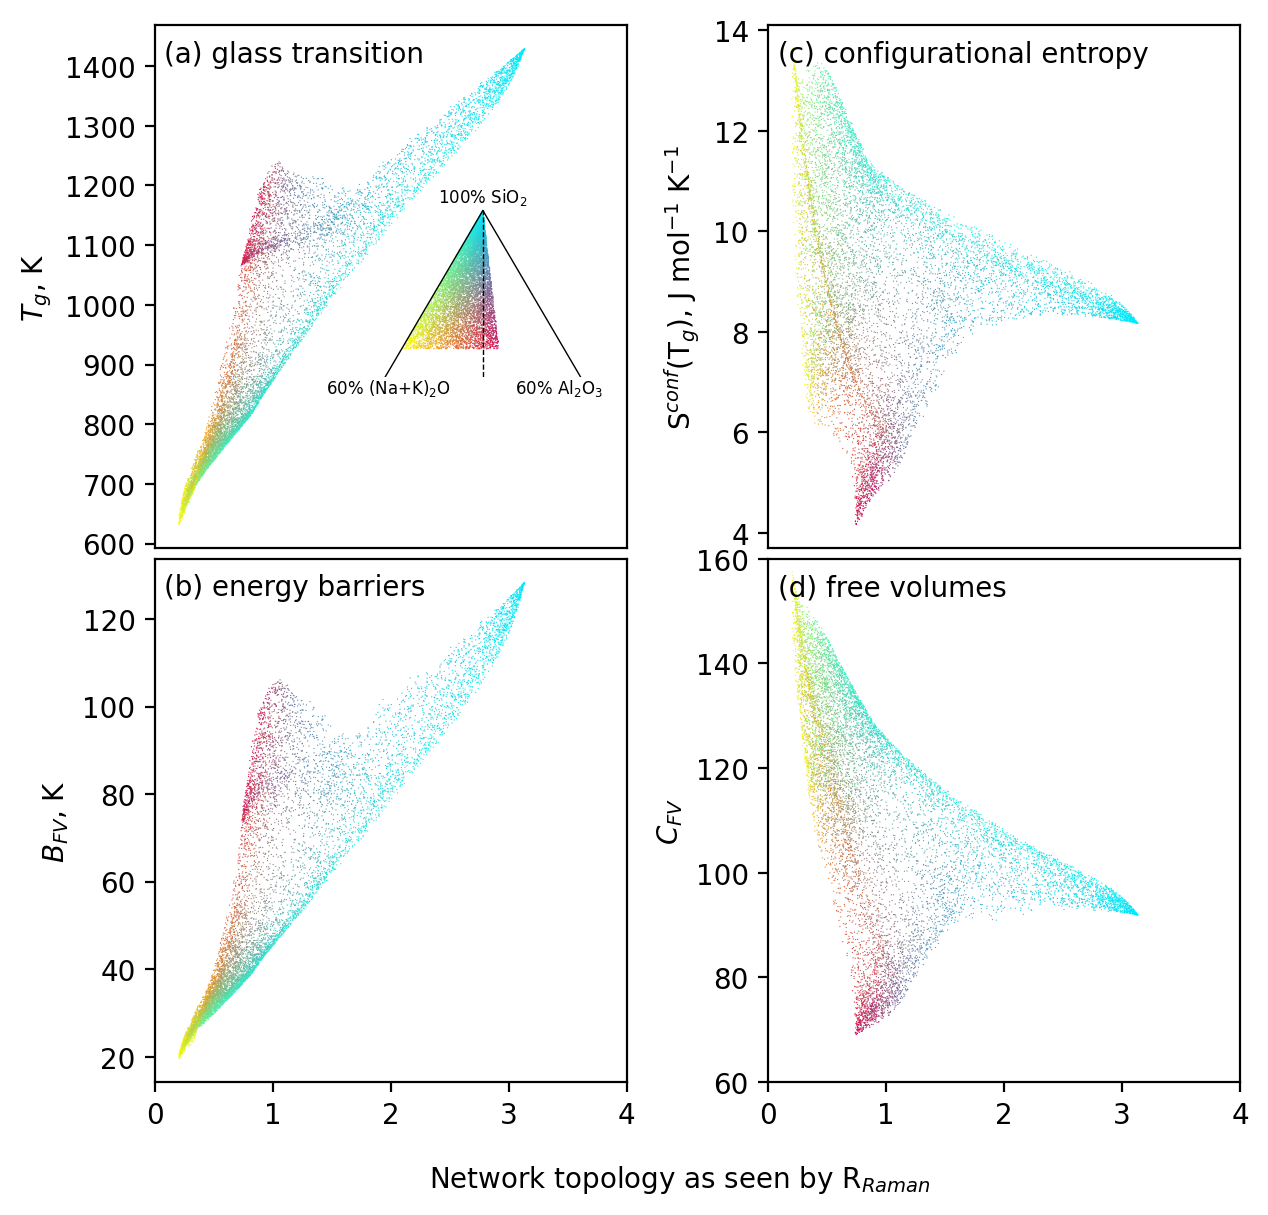

In [14]:
def CLR(input_array):
    """Transform chemical composition in colors
    
    Inputs
    ------
    input_array: n*4 array
        4 chemical inputs with sio2, al2o3, k2o and na2o in 4 columns, n samples in rows
        
    Returns
    -------
    out: n*3 array
        RGB colors
    """
    XXX = input_array.copy()
    XXX[:,2] = XXX[:,2]+XXX[:,3] # adding alkalis
    XXX2 = np.delete(XXX,3,1) # remove 4th row
    
    clr_ = XXX2.copy()
    
    clr_[:,0] = XXX2[:,0]*120 + XXX2[:,1]*220 + XXX2[:,2]*255
    clr_[:,1] = XXX2[:,0]*94 + XXX2[:,1]*38 + XXX2[:,2]*97
    clr_[:,2] = XXX2[:,0]*240 + XXX2[:,1]*127 + XXX2[:,2]*0
    #column1 = np.array([[120, 94, 240]]).reshape(1,-1)
    #column2 = np.array([[220, 38, 127]]).reshape(1,-1)
    #column3 = np.array([[254, 97, 0]]).reshape(1,-1)
    
    # min max scaling to have colors in the full choosen scale
    clr_[:,0] = (clr_[:,0]-clr_[:,0].min())/(clr_[:,0].max()-clr_[:,0].min())
    clr_[:,1] = (clr_[:,1]-clr_[:,1].min())/(clr_[:,1].max()-clr_[:,1].min())
    clr_[:,2] = (clr_[:,2]-clr_[:,2].min())/(clr_[:,2].max()-clr_[:,2].min())
    
    return clr_

CLR(X_gen.detach().numpy())

X_rec_forcart = X_rec
X_rec_forcart["alkalis"] = X_rec.na2o+X_rec.k2o
cart_rec = imelt.bary2cart(X_rec_forcart.loc[:,["alkalis","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))

fig2n = plt.figure(figsize=(7,7),dpi=200)

gs = GridSpec(2, 2, figure=fig2n, hspace=0.02, wspace=0.30)

fig2n_a = fig2n.add_subplot(gs[0, 0])
fig2n_b = fig2n.add_subplot(gs[1, 0])
fig2n_d = fig2n.add_subplot(gs[0, 1])
fig2n_e = fig2n.add_subplot(gs[1, 1])

####
#### TERNARY PLOT
####

# Create inset of width 1.3 inches and height 0.9 inches
# at the default upper right location
axins = inset_axes(fig2n_a, width=1.3, height=0.9,loc='right')

axins.scatter(cart_rec[:,0],cart_rec[:,1],s=0.2,linewidth=0.5,edgecolor='none',
              c=CLR(X_gen.detach().numpy()))
axins.plot([1,1],[0,1],"k--",linewidth=0.5)
axins.plot([0,1,2,0],[0,1,0,0],"k-",linewidth=0.5)

axins.set_xlim(0.2,1.8)
axins.set_ylim(0.4,1.05)

axins.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center",fontsize=6)
axins.annotate(r"60% Al$_2$O$_3$", xy = (1.2,0.4),xycoords="data",ha="left",va="top",fontsize=6)
axins.annotate(r"60% (Na+K)$_2$O", xy = (0.8,0.4),xycoords="data",ha="right",va="top",fontsize=6)

axins.axis("off")

####
#### DATA PLOT
####

fig2n_a.scatter(samples_2[:,4],samples_2[:,3],s=.2,edgecolor='none',c=CLR(X_gen.detach().numpy()))
fig2n_b.scatter(samples_2[:,4],samples_2[:,2],s=.2,edgecolor='none',c=CLR(X_gen.detach().numpy()))
fig2n_d.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("sctg",X_gen).mean(axis=1), s=.2,edgecolor='none',c=CLR(X_gen.detach().numpy()))
fig2n_e.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("c_cg",X_gen).mean(axis=1), s=.2,edgecolor='none',c=CLR(X_gen.detach().numpy()))
#fig2n_d.set_ylim(4,14)
fig2n_e.set_ylim(60,160)


fig2n_a.set_ylabel("$T_{g}$, K")
fig2n_b.set_ylabel("$B_{FV}$, K")
fig2n_d.set_ylabel(r"S$^{conf}$(T$_{g}$), J mol$^{-1}$ K$^{-1}$")
fig2n_e.set_ylabel(r"$C_{FV}$")
fig2n.text(0.5,0.05,'Network topology as seen by R$_{Raman}$',ha="center")

fig2n_a.set_xticks([])
fig2n_d.set_xticks([])
fig2n_b.set_xticks([0,1,2,3,4,5])
fig2n_e.set_xticks([0,1,2,3,4,5])

#
# Annotations
#
fig2n_a.annotate("(a) glass transition", xy=(0.02,0.93),xycoords="axes fraction")
fig2n_b.annotate("(b) energy barriers", xy=(0.02,0.93),xycoords="axes fraction")
fig2n_d.annotate("(c) configurational entropy", xy=(0.02,0.93),xycoords="axes fraction")
fig2n_e.annotate("(d) free volumes", xy=(0.02,0.93),xycoords="axes fraction")

fig2n_a.set_xlim(0,4)
fig2n_b.set_xlim(0,4)
fig2n_d.set_xlim(0,4)
fig2n_e.set_xlim(0,4)

print(labels_2)

#plt.tight_layout()

plt.savefig("./figures/Figure10_Rraman_properties.pdf",bbox_inches="tight")

# Figure 11: correlation matrice

Below we test Spearman correlations between variables, allows to see unlinear correlated features.

<ipython-input-15-826947ba0034>:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


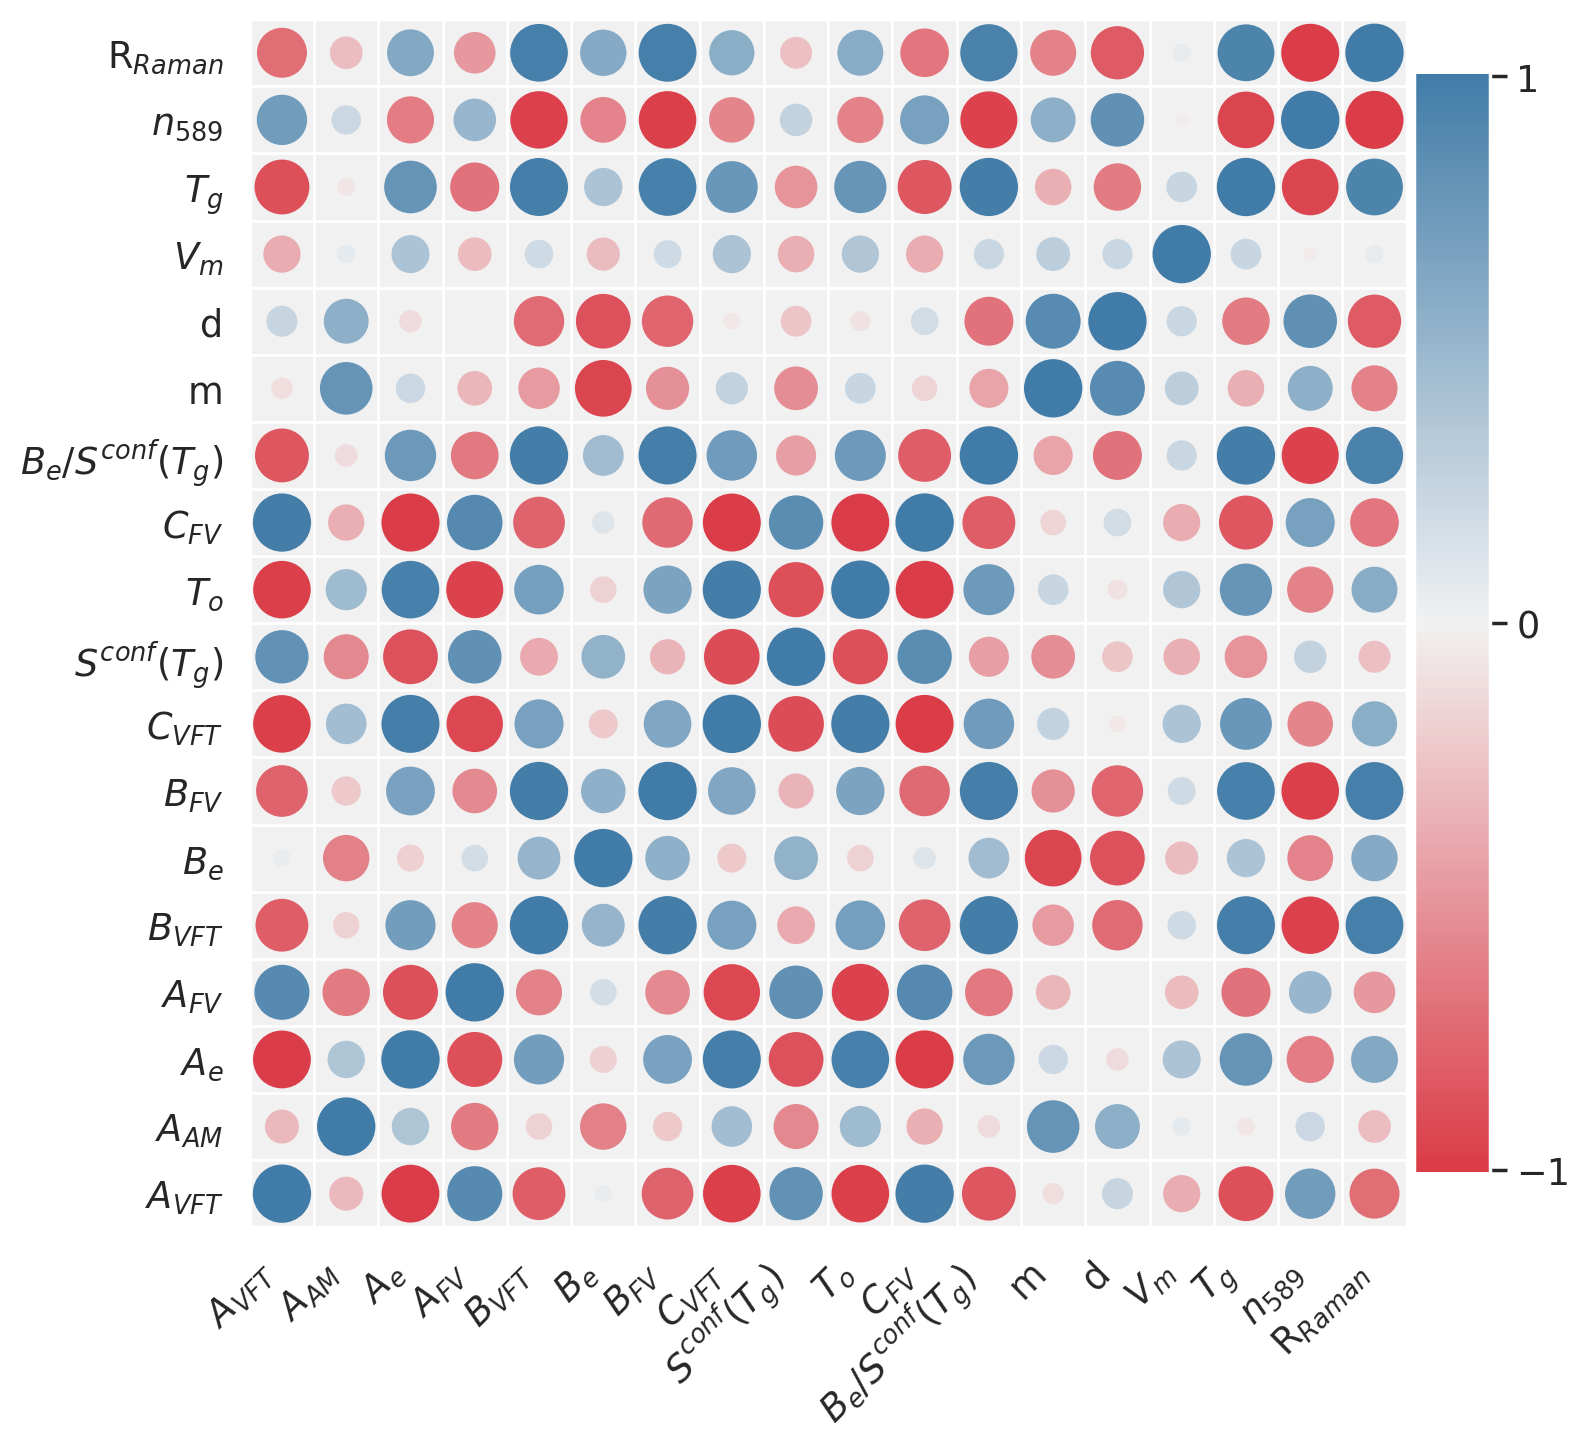

In [15]:
df_samples = pd.DataFrame(data= samples, columns=labels)

sp_corr = df_samples.corr(method="spearman")

# old figure code
#figc = plt.figure(figsize=(8,8))
#ax = plt.subplot()
#sns.heatmap(sp_corr, annot=False, fmt='.2f', center=False,
#            cmap=plt.get_cmap('coolwarm'), cbar=True, cbar_kws = {"label":"Spearman correlation coefficient"},ax=ax, vmin=-1, vmax=1)
#ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
#plt.tight_layout()

# new figure generated using heatmapz, see https://github.com/dylan-profiler/heatmaps
from heatmap import heatmap, corrplot
sns.set(color_codes=True, font_scale=1.2)
figc = plt.figure(figsize=(8,8), dpi=200)
corr = pd.melt(sp_corr.reset_index(), id_vars='index').replace(np.nan, 0)
corr.columns = ['x', 'y', 'value']
heatmap(
    corr['x'], corr['y'],
    color=corr['value'], color_range=[-1, 1],
    palette=sns.diverging_palette(10, 240, n=256),
    size=corr['value'].abs(), size_range=[0,1],
    marker='o',
    x_order=sp_corr.columns,
    y_order=sp_corr.columns[:],
    size_scale=400
)
plt.tight_layout()
plt.savefig('./figures/Figure11_correlations.pdf', bbox_inches='tight', pad_inches=0.0)

matplotlib.rc_file_defaults() # to erase sns modifications to matplotlib default

# Figure 12 : High temperature limit

<ipython-input-16-6dfb722245c3>:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


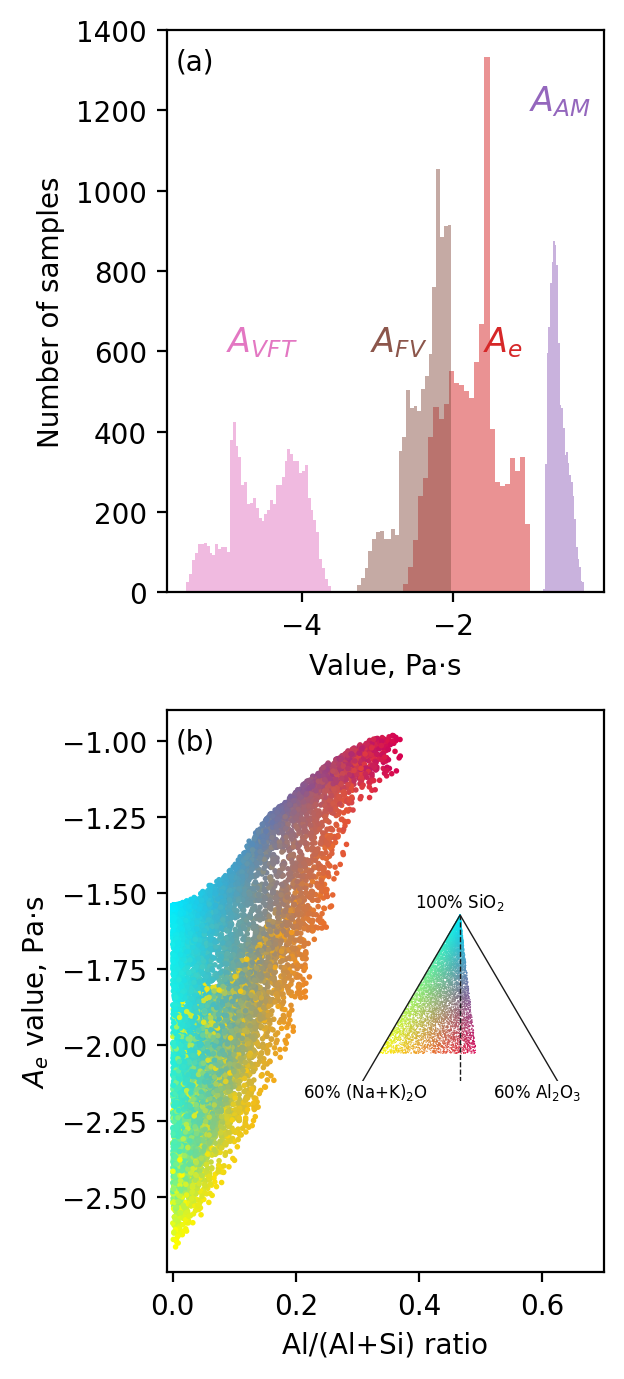

In [16]:
###
### FIRST SUBPLOT
###

plt.figure(figsize=(3.22,7), dpi=200)

ax0 = plt.subplot(2,1,1)
ax0.hist(samples[:,2],bins=25, alpha = 0.5, color="C3", density=False, label='$A_e$')
ax0.hist(samples[:,1],bins=25, alpha = 0.5, color="C4", density=False,label='$A_{AM}$')
ax0.hist(samples[:,3],bins=25, alpha = 0.5, color="C5", density=False,label='$A_{FV}$')
ax0.hist(samples[:,0],bins=50,alpha=0.5, color="C6", density=False,label='$A_{TVF}$')

ax0.annotate('$A_e$', xy=(-1.6,600),color='C3',fontsize=12)
ax0.annotate('$A_{AM}$', xy=(-1.0,1200),color='C4',fontsize=12)
ax0.annotate('$A_{FV}$', xy=(-3.1,600),color='C5',fontsize=12)
ax0.annotate('$A_{VFT}$', xy=(-5.,600),color='C6',fontsize=12)

plt.xlabel("Value, Pa$\cdot$s")
plt.ylabel("Number of samples")
plt.annotate("(a)", xy=(0.02,0.93),xycoords="axes fraction")

###
### SECOND SUBPLOT
###

ax = plt.subplot(2,1,2)
#### TERNARY INSERT PLOT

# Create inset of width 1.3 inches and height 0.9 inches
# at the default upper right location
axins = inset_axes(ax, width=1.3, height=0.9,loc="right")

axins.scatter(cart_rec[:,0],cart_rec[:,1],s=0.2,linewidth=0.5,edgecolor='none',c=CLR(X_gen.detach().numpy()))
axins.plot([1,1],[0,1],"k--",linewidth=0.5)
axins.plot([0,1,2,0],[0,1,0,0],"k-",linewidth=0.5)

axins.set_xlim(0.2,1.8)
axins.set_ylim(0.4,1.05)

axins.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center",fontsize=6)
axins.annotate(r"60% Al$_2$O$_3$", xy = (1.2,0.4),xycoords="data",ha="left",va="top",fontsize=6)
axins.annotate(r"60% (Na+K)$_2$O", xy = (0.8,0.4),xycoords="data",ha="right",va="top",fontsize=6)

axins.axis("off")

# MAIN PLOT

ax.scatter(X_gen[:,1]/(X_gen[:,0]+X_gen[:,1]),samples[:,2],s=1,c=CLR(X_gen.detach().numpy()))
ax.set_xlabel("Al/(Al+Si) ratio")
ax.set_xlim(-0.01,0.7)
ax.set_ylabel("$A_e$ value, Pa$\cdot$s")

ax.annotate("(b)", xy=(0.02,0.93),xycoords="axes fraction")

plt.tight_layout()

plt.savefig("./figures/Figure12_infinitevisco.pdf")

# Figure 13 : eruptive dynamic, and mapping of entropy and structure

In [17]:
# Loading the data from Di Genova 2017
# the spreadsheet was modified a minimum to be loaded by Pandas
dataset_DG2017 = pd.read_excel("./data/DiGenova2017-nature24488-s2-modified.xlsx")
dataset_DG2017.head()

# we group data by location
dataset_DG2017 = dataset_DG2017.groupby('Location').mean().reset_index()

# generating many simplified rhyolite compositions to calculate their properties and map them
nb_samples = 20000

X_rh = pd.DataFrame()
X_rh["sio2"] = np.random.random_sample(nb_samples)*0.04 + 0.78

R_MAl = np.random.random_sample(nb_samples)*0.4 + 0.3 # ratio of alkalis to Al
R_XK = np.random.random_sample(nb_samples) # ratio K/(K+Na)

X_rh["al2o3"] = (1.0 - R_MAl)*(1-X_rh["sio2"])
X_rh["na2o"] = (1-X_rh["sio2"]-X_rh["al2o3"])*(1-R_XK)
X_rh["k2o"] = (1-X_rh["sio2"]-X_rh["al2o3"]-X_rh["na2o"])

rh_sctg = neuralmodel.predict("sctg",torch.Tensor(X_rh.values).to(device)).mean(axis=1).reshape(-1,1)
rh_be = neuralmodel.predict("be",torch.Tensor(X_rh.values).to(device)).mean(axis=1).reshape(-1,1)

Raman_rh = neuralmodel.predict("raman_pred",X_rh.values).mean(axis=2)
Rr_rh = imelt.R_Raman(x_raman_shift, Raman_rh)

#
# Generating a trend from a sodic peralkaline to a potassic peraluminous composition
#
nb_samples2 = 200

X_rh2 = pd.DataFrame()
X_rh2["sio2"] = 0.78*np.ones(nb_samples2)

R_MAl2 = np.linspace(0.45,0.55, nb_samples2) # ratio of alkalis to Al
R_XK2 = np.linspace(0.7,0.25, nb_samples2) # ratio K/(K+Na)

X_rh2["al2o3"] = (1.0 - R_MAl2)*(1-X_rh2["sio2"])
X_rh2["na2o"] = (1-X_rh2["sio2"]-X_rh2["al2o3"])*(1-R_XK2)
X_rh2["k2o"] = (1-X_rh2["sio2"]-X_rh2["al2o3"]-X_rh2["na2o"])

def nbot_calc(X):
    O = X.na2o + X.k2o + 3*X.al2o3 + 2*X.sio2
    T = 2*X.al2o3 + X.sio2
    nbot_t = (2*O-4*T)/T
    nbot_t[nbot_t<0] = 0
    return nbot_t

rh2_agpa = (X_rh2["k2o"]+X_rh2["na2o"])/X_rh2["al2o3"]

nbot_rh2 = nbot_calc(X_rh2) # theoretical NBO/T
Raman_rh2 = neuralmodel.predict("raman_pred",X_rh2.values).mean(axis=2) # predicted Raman data
Sconf_rh2 = neuralmodel.predict("sctg", X_rh2.values, [1273])
Visco_rh2 = neuralmodel.predict("ag", X_rh2.values, [1273])

# this is for peak-fitting the generated spectra
y_raman_foranalysis = Raman_rh2.T[x_raman_shift>870,:]
x_raman_foranalysis = x_raman_shift[x_raman_shift>870]

# peak fitting the spectra

def model_peaks(x, at, ft, lt, aq3, fq3, lq3, aq4ii, fq4ii, lq4ii, aq4i, fq4i, lq4i, lin1, lin2, details=False):
    if details == False:
        return (rp.gaussian(x,at, ft, lt)+
                rp.gaussian(x,aq3, fq3, lq3)+
                rp.gaussian(x,aq4ii, fq4ii, lq4ii)+
                rp.gaussian(x,aq4i, fq4i, lq4i)+
               lin1 + lin2*(x-850))
    elif details == True:
        return rp.gaussian(x,at, ft, lt), rp.gaussian(x,aq3, fq3, lq3), rp.gaussian(x,aq4ii, fq4ii, lq4ii), rp.gaussian(x,aq4i, fq4i, lq4i), lin1 + lin2*(x-850)
    
    return objective + prior



p0 = [0.4, 1002, 60, 0.0, 1080, 23, 0.5, 1122, 60, 0.2, 1186, 60, 0.01, 0.001]        
bounds = ([0., 980, 20, 0., 1075, 20, 0., 1120, 56, 0., 1180, 20, -1,0],
              [0.8, 1020, 90, 1.0, 1090, 25, 0.8, 1124, 70, 0.8, 1190, 90, 1, 1000])
    
Q_areas = np.zeros((nb_samples2,2))
models = []
for i in range(nb_samples2):
    
    popt, pcov = curve_fit(model_peaks, 
                           x_raman_shift[x_raman_shift>870], 
                           y_raman_foranalysis[:,i], 
                           p0=p0, 
                           bounds=bounds,
                           #method="trf"
                           )
    models.append((popt,pcov))
    
    q3, _ = rp.gaussianarea(popt[3],popt[5])
    q4II, _ = rp.gaussianarea(popt[6],popt[8])
    q4I, _ = rp.gaussianarea(popt[9],popt[11])
    Q_areas[i,0] = q3
    Q_areas[i,1] = q4II+q4I
    
    
#
# WHAT DO WE PLOT?
#

plotted_structure = Rr_rh.reshape(-1)
plotted_entropy = neuralmodel.predict("sctg",torch.Tensor(X_rh.values).to(device)).mean(axis=1).reshape(-1,1)


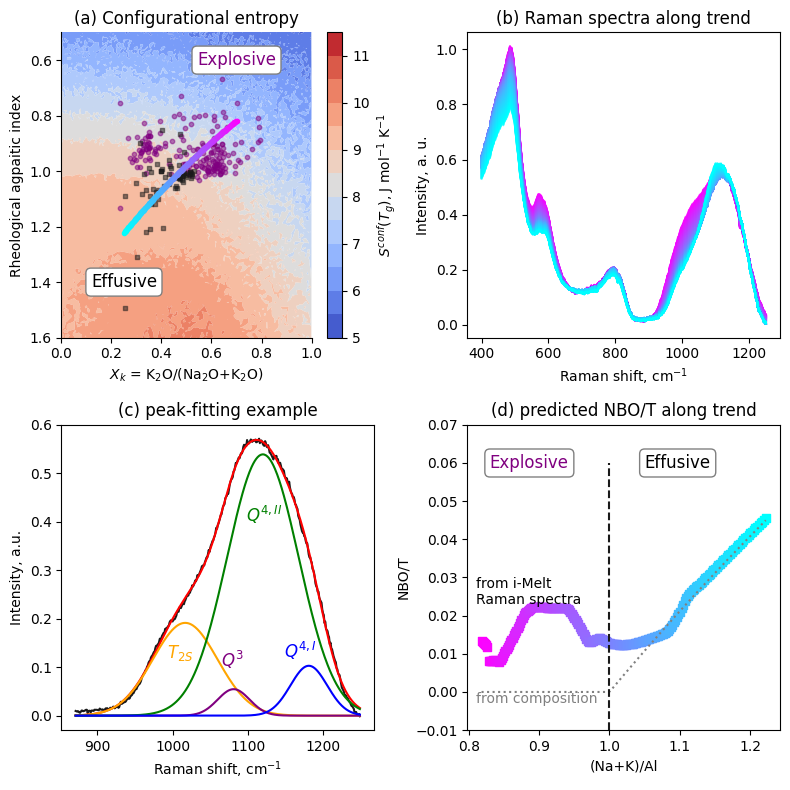

In [18]:
#
# FIGURE
#

fig4, ax = plt.subplots(2,2,figsize=(8,8))

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=1.0)

#
# SUBPLOT 0
#
ax2 = ax[0][0]

# MODEL
tc2 = ax2.tricontourf(X_rh.loc[:,"k2o"]/(X_rh.loc[:,"na2o"]+X_rh.loc[:,"k2o"]),
                (X_rh.loc[:,"na2o"]+X_rh.loc[:,"k2o"])/(X_rh.loc[:,"al2o3"]), 
                plotted_entropy.reshape(-1), 
                levels=11, cmap="coolwarm",antialiased=True)

# Now adding the colorbar and its label
cbar2 = plt.colorbar(mappable=tc2, ax=ax2)
cbar2.set_label('$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$')

# DATA
ax2.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"RAI"]),c='purple',marker="o",s=10,alpha=0.5,label="Explosif")
ax2.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"RAI"]),c='k',marker="s",s=10,alpha=0.5,label="Dôme")

ax2.text(0.7,0.6, "Explosive", ha="center", va="center", size=12, color="purple",
        bbox=bbox_props)

ax2.text(0.25, 1.4, "Effusive", ha="center", va="center", size=12, color="black",
        bbox=bbox_props)

ax2.set_xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
ax2.set_ylabel(r"Rheological agpaitic index")
ax2.set_xlim(0,1)
ax2.set_ylim(1.6,0.5)

# Hide the right and top spines
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

#
# SUBPLOT 1
#

ax1 = ax[0][1]

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(R_XK2),
    vmax=np.max(R_XK2))

# choose a colormap
c_m = matplotlib.cm.cool

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

# plotting spectra
for i in range(R_XK2.shape[0]):
    ax1.plot(x_raman_shift,
             Raman_rh2.T[:,i],
             color=s_m.to_rgba(R_XK2[i]), # calling the ScalarMappable that was initialised with c_m and norm
             alpha=0.5)
    # plotting the line with same color in subplot 0
    # trend for Raman spectra
    tc2 = ax2.scatter(X_rh2.loc[i,"k2o"]/(X_rh2.loc[i,"na2o"]+X_rh2.loc[i,"k2o"]),
                    (X_rh2.loc[i,"na2o"]+X_rh2.loc[i,"k2o"])/(X_rh2.loc[i,"al2o3"]),
                      color=s_m.to_rgba(R_XK2[i]), marker="."
                  )

    
ax1.set_ylabel("Intensity, a. u.")
ax1.set_xlabel("Raman shift, cm$^{-1}$")

#
# SUBPLOT 3
#

ax3 = ax[1][0]

idx_example = 190
popt, pcov = models[idx_example]
model_ = model_peaks(x_raman_foranalysis, *popt)
peaks_ = model_peaks(x_raman_foranalysis, *popt, details=True)

ax3.plot(x_raman_foranalysis , y_raman_foranalysis[:,idx_example]-peaks_[-1], color="k")
ax3.plot(x_raman_foranalysis , model_-peaks_[-1], color="red")

colors_ = ["orange", "purple", "green", "blue", "none"]
for idx,j in enumerate(peaks_):
    ax3.plot(x_raman_foranalysis, j, color = colors_[idx])
    
ax3.annotate("$T_{2S}$", xy=(1010, 0.12), color="orange", ha="center", fontsize=12)
ax3.annotate("$Q^{3}$", xy=(1080, 0.1), color="purple", ha="center", fontsize=12)
ax3.annotate("$Q^{4,II}$", xy=(1122, 0.4), color="green", ha="center", fontsize=12)
ax3.annotate("$Q^{4,I}$", xy=(1170, 0.12), color="blue", ha="center", fontsize=12)

ax3.set_xlabel("Raman shift, cm$^{-1}$")
ax3.set_ylabel("Intensity, a.u.")

#
# SUBPLOT 4
#

ax4 = ax[1][1]

Q_areas = Q_areas/np.sum(Q_areas, axis=1).reshape(-1,1)

nbot_peakfit = Q_areas[:,0]
plt.plot(rh2_agpa[:],nbot_rh2[:],":", c="grey")
for i in range(R_XK2.shape[0]):
    plt.scatter(rh2_agpa[i],1.05*Q_areas[i,0], color=s_m.to_rgba(R_XK2[i]), marker="s")
    
plt.ylim(-0.01,0.07)

plt.plot([1,1],[-0.01,0.06], "--", color="k")

plt.xlabel("(Na+K)/Al")
plt.ylabel("NBO/T")

plt.annotate("from i-Melt\nRaman spectra", xy=(0.81, 0.023))
plt.annotate("from composition", xy=(0.81, -0.003), color="grey")

ax4.text(0.83,0.06, "Explosive", ha="left", va="center", size=12, color="purple",
        bbox=bbox_props)

ax4.text(1.05, 0.06, "Effusive", ha="left", va="center", size=12, color="black",
        bbox=bbox_props)


ax2.set_title("(a) Configurational entropy")
ax1.set_title("(b) Raman spectra along trend")
ax3.set_title("(c) peak-fitting example")
ax4.set_title("(d) predicted NBO/T along trend")

plt.tight_layout()

plt.savefig('./figures/Figure13_agpaitic_entropy.pdf')

# Supplementary Figure 4

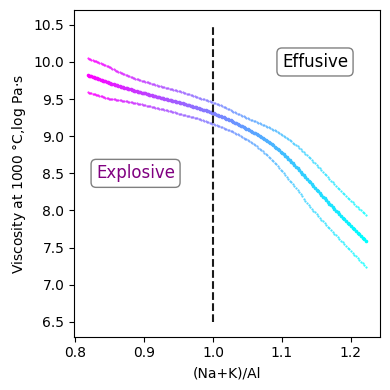

In [19]:
plt.figure(figsize=(4,4))

for i in range(R_XK2.shape[0]):
    plt.scatter(rh2_agpa[i],Visco_rh2.mean(axis=1)[i], color=s_m.to_rgba(R_XK2[i]), marker=".", s=10)
    plt.scatter(rh2_agpa[i],Visco_rh2.mean(axis=1)[i]-2*Visco_rh2.std(axis=1)[i], color=s_m.to_rgba(R_XK2[i]), marker=".", s=1)
    plt.scatter(rh2_agpa[i],Visco_rh2.mean(axis=1)[i]+2*Visco_rh2.std(axis=1)[i], color=s_m.to_rgba(R_XK2[i]), marker=".", s=1)

plt.plot([1,1],[6.5,10.5], "--", color="k")

plt.xlabel("(Na+K)/Al")
plt.ylabel("Viscosity at 1000 °C,log Pa$\cdot$s")

plt.text(0.83,8.5, "Explosive", ha="left", va="center", size=12, color="purple",
        bbox=bbox_props)

plt.text(1.10, 10.0, "Effusive", ha="left", va="center", size=12, color="black",
        bbox=bbox_props)

plt.tight_layout()
plt.savefig("./figures/Supplementary_Figure_4.pdf")

# Alkali series

In [20]:


# Sodic series
start_sio2 = 55.
stop_sio2 = 67.
start_al2o3 = 0.19*start_sio2
stop_al2o3 = 0.20*stop_sio2
start_na2o = (100-start_sio2-start_al2o3)*0.66
stop_na2o = (100-stop_sio2-stop_al2o3)*0.66
start_k2o = 100-start_sio2-start_al2o3-start_na2o
stop_k2o = 100-stop_sio2-stop_al2o3-stop_na2o

sio2_alk = np.linspace(start_sio2, stop_sio2, num=100)
al2o3_alk = np.linspace(start_al2o3, stop_al2o3, num=100)
na2o_alk = np.linspace(start_na2o, stop_na2o, num=100)
k2o_alk = np.linspace(start_k2o, stop_k2o, num=100)

X_alk = np.array([sio2_alk, al2o3_alk, na2o_alk, k2o_alk]).T
X_alk = X_alk/np.sum(X_alk,axis=1).reshape(-1,1)

X_alk = pd.DataFrame(X_alk, columns=["sio2", "al2o3", "na2o", "k2o"])
#X_alk = imelt.chimie_control(X_alk)
#X_alk = vp.wt_mol(X_alk)
nbot_alk_sodic = nbot_calc(X_alk)
print(nbot_alk_sodic)

X_alk_sodic = X_alk.loc[:,["sio2","al2o3","na2o","k2o"]]

Raman_alk_sodic = neuralmodel.predict("raman_pred",X_alk_sodic.values).mean(axis=2)
sctg_alk_sodic = neuralmodel.predict("sctg",X_alk_sodic.values)#.mean(axis=1)
fragility_alk_sodic = neuralmodel.predict("fragility",X_alk_sodic.values)#.mean(axis=1)
tg_alk_sodic = neuralmodel.predict("tg",X_alk_sodic.values)#.mean(axis=1)
visco_alk_sodic= neuralmodel.predict("ag",X_alk_sodic.values, [1373.0])

# Potassic series
# adjusting the alkalis
start_na2o = (100-start_sio2-start_al2o3)*0.33
stop_na2o = (100-stop_sio2-stop_al2o3)*0.33
start_k2o = 100-start_sio2-start_al2o3-start_na2o
stop_k2o = 100-stop_sio2-stop_al2o3-stop_na2o

sio2_alk = np.linspace(start_sio2, stop_sio2, num=100)
al2o3_alk = np.linspace(start_al2o3, stop_al2o3, num=100)
na2o_alk = np.linspace(start_na2o, stop_na2o, num=100)
k2o_alk = np.linspace(start_k2o, stop_k2o, num=100)

X_alk = np.array([sio2_alk, al2o3_alk, na2o_alk, k2o_alk]).T
X_alk = X_alk/np.sum(X_alk,axis=1).reshape(-1,1)

X_alk = pd.DataFrame(X_alk, columns=["sio2", "al2o3", "na2o", "k2o"])
#X_alk = imelt.chimie_control(X_alk)
#X_alk = vp.wt_mol(X_alk)
nbot_alk_potassic = nbot_calc(X_alk)
print(nbot_alk_potassic)

X_alk_potassic = X_alk.loc[:,["sio2","al2o3","na2o","k2o"]]

Raman_alk_potassic = neuralmodel.predict("raman_pred",X_alk_potassic.values).mean(axis=2)
sctg_alk_potassic = neuralmodel.predict("sctg",X_alk_potassic.values)#.mean(axis=1)
fragility_alk_potassic = neuralmodel.predict("fragility",X_alk_potassic.values)#.mean(axis=1)
tg_alk_potassic = neuralmodel.predict("tg",X_alk_potassic.values)#.mean(axis=1)
visco_alk_potassic= neuralmodel.predict("ag",X_alk_potassic.values, [1373.0])#.mean(axis=1)

0     0.635046
1     0.628784
2     0.622551
3     0.616348
4     0.610174
        ...   
95    0.148764
96    0.144598
97    0.140448
98    0.136314
99    0.132196
Length: 100, dtype: float64
0     0.635046
1     0.628784
2     0.622551
3     0.616348
4     0.610174
        ...   
95    0.148764
96    0.144598
97    0.140448
98    0.136314
99    0.132196
Length: 100, dtype: float64


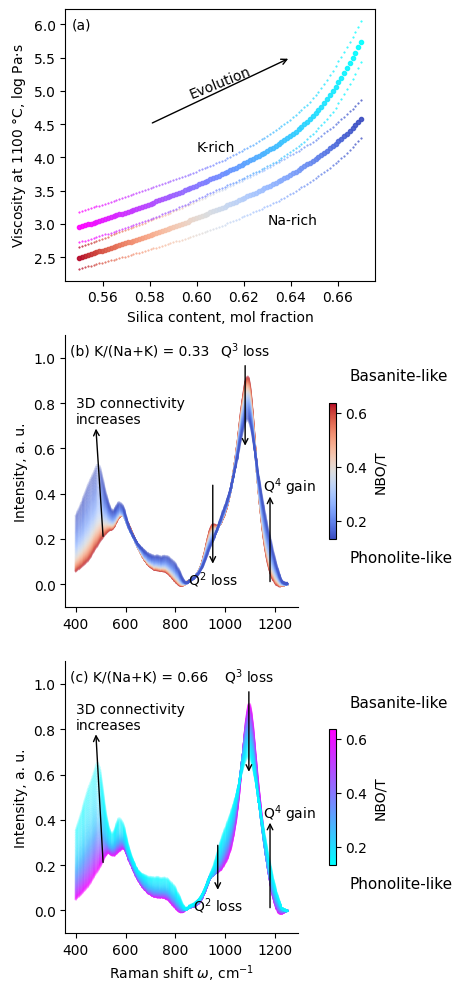

In [21]:
#
# CODE FOR COLORMAP
#
# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(nbot_alk_potassic),
    vmax=np.max(nbot_alk_potassic))

# choose a colormap
c_m = matplotlib.cm.coolwarm
c_m_k =  matplotlib.cm.cool

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

s_m_k = matplotlib.cm.ScalarMappable(cmap=c_m_k, norm=norm)
s_m_k.set_array([])

plt.figure(figsize=(4,12))

#
# VISCOSITY
#
ax2 = plt.subplot(3,1,1)

# SODIC
for i in range(X_alk_sodic.sio2.shape[0]):
    ax2.scatter(X_alk.sio2[i], visco_alk_sodic.mean(axis=1)[i], 
                marker='.',
                color=s_m.to_rgba(nbot_alk_sodic[i]), # calling the ScalarMappable that was initialised with c_m and norm
             alpha=0.9)
    
    ax2.scatter(X_alk.sio2[i], 
                visco_alk_sodic.mean(axis=1)[i] - 2*visco_alk_sodic.std(axis=1)[i], 
                marker='.',
                s=1,
                color=s_m.to_rgba(nbot_alk_sodic[i]), # calling the ScalarMappable that was initialised with c_m and norm
             alpha=0.9)
    
    ax2.scatter(X_alk.sio2[i], 
                visco_alk_sodic.mean(axis=1)[i] + 2*visco_alk_sodic.std(axis=1)[i],
                marker='.',
                s=1,
                color=s_m.to_rgba(nbot_alk_sodic[i]), # calling the ScalarMappable that was initialised with c_m and norm
             alpha=0.9)
    
# POTASSIC
for i in range(X_alk_potassic.sio2.shape[0]):
    ax2.scatter(X_alk.sio2[i], visco_alk_potassic.mean(axis=1)[i], 
                marker='.',
                color=s_m_k.to_rgba(nbot_alk_potassic[i]), # calling the ScalarMappable that was initialised with c_m and norm
             alpha=0.9)
    
    ax2.scatter(X_alk.sio2[i], 
                visco_alk_potassic.mean(axis=1)[i] - 2*visco_alk_potassic.std(axis=1)[i], 
                marker='.',
                s=1,
                color=s_m_k.to_rgba(nbot_alk_sodic[i]), # calling the ScalarMappable that was initialised with c_m and norm
             alpha=0.9)
    
    ax2.scatter(X_alk.sio2[i], 
                visco_alk_potassic.mean(axis=1)[i] + 2*visco_alk_potassic.std(axis=1)[i],
                marker='.',
                s=1,
                color=s_m_k.to_rgba(nbot_alk_potassic[i]), # calling the ScalarMappable that was initialised with c_m and norm
             alpha=0.9)

ax2.set_ylabel("Viscosity at 1100 °C, log Pa$\cdot$s")
ax2.set_xlabel("Silica content, mol fraction")

#
# SODIC RAMAN SPECTRA
#

ax3 = plt.subplot(3,1,2)

# plotting spectra
for i in range(X_alk_sodic.sio2.shape[0]):
    plt.plot(x_raman_shift,
             Raman_alk_sodic.T[:,i],
             color=s_m.to_rgba(nbot_alk_sodic[i]), # calling the ScalarMappable that was initialised with c_m and norm
             alpha=0.2)

plt.ylabel("Intensity, a. u.")

plt.annotate("", xy=(510, 0.2), xytext=(480, 0.7),arrowprops=dict(arrowstyle="<-"), ha="center")
plt.text(400,0.71, "3D connectivity \nincreases")

plt.annotate(r"Q$^2$ loss", xy=(950, 0.45), xytext=(950, 0.0),arrowprops=dict(arrowstyle="<-"), ha="center")
plt.annotate(r"Q$^3$ loss", xy=(1080, 0.6), xytext=(1080, 1.01),arrowprops=dict(arrowstyle="->"), ha="center")

plt.annotate(r"", xy=(1180, 0.0), xytext=(1180, 0.4),arrowprops=dict(arrowstyle="<-"), ha="center")
plt.text(1150, 0.41, "Q$^4$ gain")

plt.ylim(-0.1,1.1)

#
# POTASSIC RAMAN SPECTRA
#

ax4 = plt.subplot(3,1,3)

for i in range(X_alk.sio2.shape[0]):
    plt.plot(x_raman_shift,
             Raman_alk_potassic.T[:,i],
             color=s_m_k.to_rgba(nbot_alk_potassic[i]),
             alpha=0.2)

plt.ylim(-0.1,1.1)
plt.ylabel("Intensity, a. u.")

plt.annotate("", xy=(510, 0.2), xytext=(480, 0.79),arrowprops=dict(arrowstyle="<-"), ha="center")
plt.text(400,0.80, "3D connectivity \nincreases")

plt.annotate(r"Q$^2$ loss", xy=(970, 0.30), xytext=(970, 0.0),arrowprops=dict(arrowstyle="<-"), ha="center")
plt.annotate(r"Q$^3$ loss", xy=(1095, 0.6), xytext=(1095, 1.01),arrowprops=dict(arrowstyle="->"), ha="center")

plt.annotate(r"", xy=(1180, 0.0), xytext=(1180, 0.4),arrowprops=dict(arrowstyle="<-"), ha="center")
plt.text(1150, 0.41, "Q$^4$ gain")

ax3.spines['right'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines['top'].set_visible(False)

#plt.tight_layout()

ax2.annotate("(a)", xy=(0.02,0.93), xycoords="axes fraction", fontsize=10)
ax3.annotate("(b) K/(Na+K) = 0.33", xy=(0.02,0.93), xycoords="axes fraction", fontsize=10)
ax4.annotate("(c) K/(Na+K) = 0.66", xy=(0.02,0.93), xycoords="axes fraction", fontsize=10)
ax4.set_xlabel("Raman shift $\omega$, cm$^{-1}$")

ax2.annotate("", xy=(0.64, 5.5), xytext=(0.58, 4.5),arrowprops=dict(arrowstyle="->"), ha="center")
ax2.annotate("Evolution", xy=(0.61, 4.9), rotation=22, ha="center")

# Common colorbar
cbar_1 = plt.colorbar(mappable=s_m,ax=[ax3],orientation="vertical",pad=0.10, shrink=0.5)
cbar_1.set_label(r"NBO/T")

cbar_1 = plt.colorbar(mappable=s_m_k,ax=[ax4],orientation="vertical",pad=0.10, shrink=0.5)
cbar_1.set_label(r"NBO/T")

ax3.text(1500, 0.1, "Phonolite-like", fontsize=11)
ax3.text(1500, 0.9, "Basanite-like", fontsize=11)

ax4.text(1500, 0.1, "Phonolite-like", fontsize=11)
ax4.text(1500, 0.9, "Basanite-like", fontsize=11)

ax2.text(0.6, 4.1, "K-rich")
ax2.text(0.63, 3.0, "Na-rich")

plt.savefig("./figures/Figure14.pdf")
